## Predicting the onset of Alzheimer's disease using machine learning 

### Authors

Vipul Satone$^{1}$, Rachneet Kaur$^{1}$, Faraz Faghri$^{2, 3}$, Roy H. Campbell$^{3}$

1 - Department of Industrial and Enterprise Systems Engineering, University of Illinois Urbana-Champaign, IL, 61820, USA

2 - Laboratory of Neurogenetics, National Institute on Aging, National Institutes of Health, MD, 20892, USA

3 - Department of Computer Science, University of Illinois Urbana-Champaign, IL, 61820, USA

### Abstract

*Background*: Treating Alzheimer's disease(AD) is a challenging task due to the variations present in the disease progression. There is an unfulfilled need for an early prediction of the disease course to assist it's treatment. With recent developments in the regime of machine learning, a huge potential now exists to predict the onset and progression of AD and to sub classify the disease into different subgroups. 

*Methods and Findings*: The suggested work clusters patients in distinct progression groups of Alzheimer's disease and discusses an approach to predict the progression stage in an early baseline period. Dimensionality reduction was used to identify progression space for the Alzheimer’s disease. This work suggests that the clinically related symptoms summarizing the Alzheimer's Disease progression space correspond to memory and cognition. Gaussian Mixture Model was used to cluster different progression. For the discussed approach, predictive model uses Random Forest to give best area under the curve (AUC) of the Receiver operating characteristic (ROC) of  0.94  0.03. for controls, 0.97  0.02 for High risk, 0.88  0.05 for Low risk and 0.91  0.05 for moderate risk for 24th month using baseline and 12 months of observation. Prediction of progression at 48th month using baseline and 12 months of observation yields AUC under ROC of 0.90  0.04 for controls, 0.94  0.08 for High risk, 0.85  0.02 for Low risk and 0.91  0.04 for moderate risk. Accuracy for prediction of progression at 24th and 48th month is 83.60 % and 77.33 % respectively.

*Conclusions*: The machine learning techniques will enable the medical practitioners to classify different progression rates within their patients. This might improve detection of significant clinical outcomes that otherwise may be harder to notice. Furthermore, the proposed approach will improve distinctive and personalized clinical care.

#### Imports 

In [7]:
#Importing libraries 
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm
#from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics 
import pandas as pd
from sklearn import decomposition
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
import imageio
import warnings
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

In [13]:
#Keeping the directory correct
import os

os.chdir('C:\\Users\\Rachneet Kaur\\Desktop\\UIUC\\UIUC Fall 2018\\HDA\\CS598HDAProject\\AlziemersData\\') # default directory
address = 'C:\\Users\\Rachneet Kaur\\Desktop\\UIUC\\UIUC Fall 2018\\HDA\\CS598HDAProject\\AlziemersData\\ADNI\\Processed_Data' # directory where images are to be stored
# Inside this folder (m24_m12) have a folder gif. Inside this folder have three different folders named ica, pca, nmf.

In [14]:
# assessment data
cols = {}
list_months_to_be_considered = ['bl','m06','m12']

#### Function to display dataset information

In [15]:
# Following function gives information about dataset to be imputed.
def data_info(dataset):
    print('Name of dataset is: ' + dataset.name) 
    print('\n0th level of columns is ')
    print(list(pd.Series(dataset.columns.get_level_values(0)).unique()) )
    print('\n1st level of columns is: ')
    print(list(pd.Series(dataset.columns.get_level_values(1)).unique()) )
    print('\nShape of datset is:')
    print(dataset.shape)
    print('\nTotal number of missing values: ')
    print(dataset.isnull().sum().sum())

In [16]:
# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1

#### Datasets Cleaning and imputation.

In [17]:

#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
cdr = cdr[cdr['VISCODE2'].isin(['bl','m12','m06']) ]  
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = cdr_ruf.iloc[:,0] +  '___' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr

cdr.name = 'Clinical Dementia Rating'


In [18]:

#NPIQ
cols['npiq'] = ['RID', 'VISCODE2', 'NPIASEV','NPIBSEV', 'NPICSEV','NPIDSEV', 'NPIESEV', 'NPIFSEV',      'NPIGSEV',  'NPIHSEV','NPIISEV',  'NPIJSEV',  'NPIKSEV', 'NPILSEV', 'NPIA','NPIB', 'NPIC','NPID'    , 'NPIE', 'NPIF','NPIG',  'NPIH','NPII',  'NPIJ',  'NPIK', 'NPIL']
npiq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPIQ.csv', usecols=cols['npiq'], index_col = ['RID', 'VISCODE2'])
npiq1 = npiq.copy(deep = True) 
# there are some values which are -1 instead of 2 . replacing them with 2 to indicate readings not taken
npiq = npiq.replace({-1: 2})
#Replcing all -4 to 0 
npiq = npiq[~npiq.index.duplicated()].reset_index()
npiq = npiq[npiq.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
# removing observations with 2 (ie. no readings)
npiq = npiq[ ~( (npiq.NPIA == 2) | (npiq.NPIB == 2) | (npiq.NPIC == 2) | (npiq.NPID == 2) |     (npiq.NPIE == 2) | (npiq.NPIF == 2) | (npiq.NPIG == 2) | (npiq.NPIH == 2) | (npiq.NPII == 2) |     (npiq.NPIJ == 2) | (npiq.NPIK == 2) | (npiq.NPIL == 2) ) ]
#Multiplying whether of not with the severity ratings
npiq['NPIA_total'] = npiq['NPIA']*npiq['NPIASEV']
npiq['NPIB_total'] = npiq['NPIB']*npiq['NPIBSEV']
npiq['NPIC_total'] = npiq['NPIC']*npiq['NPICSEV']
npiq['NPID_total'] = npiq['NPID']*npiq['NPIDSEV']
npiq['NPIE_total'] = npiq['NPIE']*npiq['NPIESEV']
npiq['NPIF_total'] = npiq['NPIF']*npiq['NPIFSEV']
npiq['NPIG_total'] = npiq['NPIG']*npiq['NPIGSEV']
npiq['NPIH_total'] = npiq['NPIH']*npiq['NPIHSEV']
npiq['NPII_total'] = npiq['NPII']*npiq['NPIISEV']
npiq['NPIJ_total'] = npiq['NPIJ']*npiq['NPIJSEV']
npiq['NPIK_total'] = npiq['NPIK']*npiq['NPIKSEV']
npiq['NPIL_total'] = npiq['NPIL']*npiq['NPILSEV']
npiq = npiq.replace({-0: 0})
#Taking the multiplied columns only 
npiq = npiq[['NPIA_total', 'NPIB_total', 'NPIC_total', 'NPID_total', 'NPIE_total', 'NPIF_total', 'NPIG_total',             'NPIH_total', 'NPII_total', 'NPIJ_total', 'NPIK_total', 'NPIL_total']] # drop extra

new_col_list = ['NPIA_total', 'NPIB_total', 'NPIC_total', 'NPID_total', 'NPIE_total', 'NPIF_total',                'NPIG_total','NPIH_total', 'NPII_total', 'NPIJ_total', 'NPIK_total', 'NPIL_total']
npiq = npiq.unstack()
npiq = npiq[ (npiq.isnull().sum(axis = 1) < 15) ]
for a in new_col_list: 
    npiq[a] = npiq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
npiq.name = 'Neuropsychiatric Inventory Q'
#data_info(npiq)


#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'
#data_info(neurobat_clock)

cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'
#data_info(neurobat_copy)

cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'
#data_info(neurobat_limm_story)

cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'
#data_info(neurobat_dspan)

cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'
#data_info(neurobat_cat_flu)

cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'
#data_info(neurobat_trail)

cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'
#data_info(neurobat_av)

cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'
#data_info(neurobat_digit_score)

cols['neurobat_logical_memory'] = ['RID', 'VISCODE2','LDELTOTAL','LDELCUE']
neurobat_logical_memory = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_logical_memory'], index_col = ['RID', 'VISCODE2'])
neurobat_logical_memory1 = neurobat_logical_memory.copy(deep = True) 
neurobat_logical_memory = neurobat_logical_memory[~neurobat_logical_memory.index.duplicated()].reset_index()
neurobat_logical_memory = neurobat_logical_memory[neurobat_logical_memory.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_logical_memory = neurobat_logical_memory[ (neurobat_logical_memory.isnull().sum(axis = 1) < 1) ]
neurobat_logical_memory = neurobat_logical_memory.unstack()
neurobat_logical_memory.name = 'Neuropsychological Battery (subdata - logical memeory test)'
#data_info(neurobat_logical_memory)

cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'
#data_info(neurobat_boston_naming_test)

cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'
#data_info(neurobat_anrt)

neurobat1 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_trail , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat1 = neurobat1.T
neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
neurobat1_ruf = neurobat1.T.reset_index()
neurobat1_ruf.iloc[:,0]  = neurobat1_ruf.iloc[:,0] +  '___' + neurobat1_ruf.iloc[:,1]
neurobat1_ruf = neurobat1_ruf.set_index('level_0')
neurobat1 = neurobat1_ruf.iloc[:,1:].T
neurobat1_no_encoding = neurobat1



neurobat1.name = 'Neuropsychological Battery (All combined)'

In [19]:
#ADASCORES
cols['adascores'] = ['RID', 'TOTALMOD', 'VISCODE','Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10',    'Q11','Q12','Q14']
adascores = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ADASSCORES.csv",index_col='RID', usecols=cols['adascores'])
adascores1 = adascores.copy(deep = True)
adascores1['VISCODE2'] = adascores1['VISCODE']
del adascores1['VISCODE']
adascores['VISCODE2'] = adascores['VISCODE']
del adascores['VISCODE']
adascores = adascores[adascores['VISCODE2'].isin(['m06','m12','bl']) ]  
adascores = adascores.reset_index().set_index(['RID','VISCODE2'])
adascores = adascores.replace({-4:np.NAN})
adascores = adascores[~adascores.index.duplicated()].unstack()
adascores = adascores[ (adascores.isnull().sum(axis = 1) <25) ]
new_col_list_adascores = adascores.columns.levels[0]
for a in new_col_list_adascores: 
    adascores[a] = adascores[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
adascores = adascores[ (adascores.isnull().sum(axis = 1) <1) ]
adascores = adascores.T
adascores = adascores[adascores.index.get_level_values(1).isin(list_months_to_be_considered)].T

# reducing index level
adascores_ruf = adascores.T.reset_index()
adascores_ruf.iloc[:,0]  = adascores_ruf.iloc[:,0] +  '___' + adascores_ruf.iloc[:,1]
adascores_ruf = adascores_ruf.set_index('level_0')
adascores = adascores_ruf.iloc[:,1:].T
adascores_no_encoding = adascores


adascores.name = 'Neuropsychological Battery (subdata - American national reading test)'


In [20]:
#RECBLLOG
cols['recbllog'] = ['RID','VISCODE2', 'BSXSYMNO', 'BSXSEVER', 'BSXCHRON','BSXCONTD']
recbllog = pd.read_csv('ADNI\\Raw_Data\\medical\\RECBLLOG.csv', usecols=cols['recbllog'], index_col = ['RID', 'VISCODE2'])
recbllog1 = recbllog.copy(deep = True) 
recbllog = recbllog[~recbllog.index.duplicated()].reset_index()
recbllog = recbllog[recbllog.VISCODE2.isin(['bl'])]
del recbllog['VISCODE2']
recbllog = recbllog[~recbllog.index.duplicated()]
recbllog = recbllog[ (recbllog.isnull().sum(axis = 1) < 2) ]
recbllog['BSXSYMNO']= recbllog.BSXSYMNO.replace(list(range(1,29)),['Nausea','Vomiting','Diarrhea','Constipation','Abdominal discomfort','Sweating','Dizziness','Low energy','Drowsiness','Blurred vision','Headache','Dry mouth','Shortness of breath','Coughing','Palpitations','Chest pain','Urinary discomfort','Urinary frequency', 'Ankle swelling','Musculoskeletal pain','Rash','Insomnia','Depressed mood','Crying','Elevated mood','Wandering','Fall','Other'])
recbllog =recbllog.set_index(['RID','BSXSYMNO'])
recbllog['BSXCONTD']= recbllog.BSXCONTD.replace([0],[2])
#Unstacking 
recbllog = recbllog.unstack()
recbllog = recbllog.fillna(0)
recbllog = recbllog.T.swaplevel(i=0, j=1, axis=0)
recbllog = recbllog.T
recbllog2 = recbllog.copy(deep = True)
recbllog2['VISCODE2'] = 'bl'
recbllog2.name = 'Baseline Symptome'
data_info(recbllog2)


Name of dataset is: Baseline Symptome

0th level of columns is 
['Abdominal discomfort', 'Ankle swelling', 'Blurred vision', 'Constipation', 'Coughing', 'Crying', 'Depressed mood', 'Diarrhea', 'Dizziness', 'Drowsiness', 'Dry mouth', 'Fall', 'Headache', 'Insomnia', 'Low energy', 'Musculoskeletal pain', 'Nausea', 'Other', 'Palpitations', 'Rash', 'Shortness of breath', 'Sweating', 'Urinary discomfort', 'Urinary frequency', 'Vomiting', 'Wandering', 'VISCODE2']

1st level of columns is: 
['BSXSEVER', 'BSXCHRON', 'BSXCONTD', '']

Shape of datset is:
(606, 79)

Total number of missing values: 
0


In [21]:
#MMSE
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE','MMDATE','MMYEAR','MMMONTH','MMDAY','MMSEASON','MMHOSPIT',    'MMFLOOR','MMCITY','MMAREA','MMSTATE','MMBALL','MMFLAG','MMTREE','MMD','MML','MMR','MMO','MMW',    'MMBALLDL','MMFLAGDL','MMTREEDL','MMWATCH','MMPENCIL','MMREPEAT','MMHAND','MMFOLD','MMONFLR','MMREAD',    'MMWRITE','MMDRAW']
mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 10) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 20) ]
mmse = mmse[~mmse.index.duplicated()]
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin(list_months_to_be_considered)].T

# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = mmse_ruf.iloc[:,0] +  '___' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T


mmse_no_encoding = mmse


# Hot encoding
mmse_name_list = list( mmse.columns )
mmse_empty = pd.DataFrame()
for i in range(len(mmse_name_list)):
    name = mmse_name_list[i]
    mmse_with_dummies = pd.get_dummies(mmse[name], sparse=True, drop_first=True, prefix=name)
    mmse_empty = pd.concat([mmse_empty,mmse_with_dummies] , axis = 1)
    
mmse = mmse_empty    



mmse.name = 'Mini Mental State Exam'

In [22]:
#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin(['bl','m12','m06']) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(list_months_to_be_considered)].T


# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = geriatric_ruf.iloc[:,0] +  '___' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric

geriatric.name = 'Geriatric depression scale'

In [23]:
#UWNPSYCHSUM_10_27_17
cols['UWNPSYCHSUM_10_27_17'] = ['RID', 'VISCODE2', 'ADNI_MEM', 'ADNI_EF']
uwn = pd.DataFrame(pd.read_csv("ADNI\\Raw_Data\\Assessment\\UWNPSYCHSUM_10_27_17.csv",index_col= ['RID','VISCODE2'], usecols=cols['UWNPSYCHSUM_10_27_17']))
uwn1 = uwn.copy(deep = True)
uwn = uwn[~uwn.index.duplicated()].reset_index()
uwn = uwn[uwn.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
uwn = uwn[~uwn.index.duplicated()].unstack()
uwn = uwn[ (uwn.isnull().sum(axis = 1) < 3) ]
new_col_list_uwn = uwn.columns.levels[0]
for a in new_col_list_uwn: 
    uwn[a] = uwn[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
uwn = uwn[ (uwn.isnull().sum(axis = 1) <1) ]
uwn = uwn.T
uwn = uwn[uwn.index.get_level_values(1).isin(list_months_to_be_considered)].T



# reducing index level
uwn_ruf = uwn.T.reset_index()
uwn_ruf.iloc[:,0]  = uwn_ruf.iloc[:,0] +  '___' + uwn_ruf.iloc[:,1]
uwn_ruf = uwn_ruf.set_index('level_0')
uwn = uwn_ruf.iloc[:,1:].T
uwn_no_encoding = uwn



uwn.name = 'Crane Lab (UW) Neuropsych Summary Score'

In [24]:
#BLSCHECK
cols['blscheck'] = ['RID', 'VISCODE2', 'BCNAUSEA', 'BCVOMIT', 'BCDIARRH', 'BCCONSTP',
       'BCABDOMN', 'BCSWEATN', 'BCDIZZY', 'BCENERGY', 'BCDROWSY', 'BCVISION',
       'BCHDACHE', 'BCDRYMTH', 'BCBREATH', 'BCCOUGH', 'BCPALPIT', 'BCCHEST',
       'BCURNDIS', 'BCURNFRQ', 'BCANKLE', 'BCMUSCLE', 'BCRASH', 'BCINSOMN',
       'BCDPMOOD', 'BCCRYING', 'BCELMOOD', 'BCWANDER', 'BCFALL']
blscheck = pd.read_csv("ADNI\\Raw_Data\\medical\\BLSCHECK.csv", index_col='RID', usecols=cols['blscheck'])
blscheck1 = blscheck.copy(deep = True)
blscheck_adni2 = blscheck[blscheck['VISCODE2'].isin(['sc']) ]  
blscheck_adni2 = blscheck_adni2.reset_index().set_index(['RID','VISCODE2'])
blscheck_adni2 = blscheck_adni2[ (blscheck_adni2.isnull().sum(axis = 1) <15) ]
blscheck_adni2 = blscheck_adni2[~blscheck_adni2.index.duplicated()].unstack()
blscheck_adni2.name = 'baseline symptoms for adni2'
data_info(blscheck_adni2)
blscheck_adni1 = blscheck[blscheck['VISCODE2'].isin(['bl']) ]  
blscheck_adni1 = blscheck_adni1.reset_index().set_index(['RID','VISCODE2'])
blscheck_adni1 = blscheck_adni1[~blscheck_adni1.index.duplicated()].unstack()
blscheck_adni1 = blscheck_adni1.T
blscheck_adni1 = blscheck_adni1[blscheck_adni1.index.get_level_values(1).isin(list_months_to_be_considered)].T


# reducing index level
blscheck_adni1_ruf = blscheck_adni1.T.reset_index()
blscheck_adni1_ruf.iloc[:,0]  = blscheck_adni1_ruf.iloc[:,0] +  '___' + blscheck_adni1_ruf.iloc[:,1]
blscheck_adni1_ruf = blscheck_adni1_ruf.set_index('level_0')
blscheck_adni1 = blscheck_adni1_ruf.iloc[:,1:].T
blscheck_adni1_no_encoding = blscheck_adni1


# Hot encoding
blscheck_adni1_name_list = list( blscheck_adni1.columns )
blscheck_adni1_empty = pd.DataFrame()
for i in range(len(blscheck_adni1_name_list)):
    name = blscheck_adni1_name_list[i]
    blscheck_adni1_with_dummies = pd.get_dummies(blscheck_adni1[name], sparse=True, drop_first=True, prefix=name)
    blscheck_adni1_empty = pd.concat([blscheck_adni1_empty,blscheck_adni1_with_dummies] , axis = 1)
    
blscheck_adni1 = blscheck_adni1_empty    

blscheck_adni1.name = 'baseline symptoms for adni1'

Name of dataset is: baseline symptoms for adni2

0th level of columns is 
['BCNAUSEA', 'BCVOMIT', 'BCDIARRH', 'BCCONSTP', 'BCABDOMN', 'BCSWEATN', 'BCDIZZY', 'BCENERGY', 'BCDROWSY', 'BCVISION', 'BCHDACHE', 'BCDRYMTH', 'BCBREATH', 'BCCOUGH', 'BCPALPIT', 'BCCHEST', 'BCURNDIS', 'BCURNFRQ', 'BCANKLE', 'BCMUSCLE', 'BCRASH', 'BCINSOMN', 'BCDPMOOD', 'BCCRYING', 'BCELMOOD', 'BCWANDER', 'BCFALL']

1st level of columns is: 
['sc']

Shape of datset is:
(1325, 27)

Total number of missing values: 
0


In [25]:
#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPIBTOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIFTOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True) 
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(list_months_to_be_considered)].T



# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = npi_all_ruf.iloc[:,0] +  '___' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all

In [26]:
#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])
ecogsp1 = ecogsp.copy(deep = True)
ecogsp = ecogsp[ecogsp['VISCODE2'].isin(['bl','m12','m06']) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 41) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <1) ]
ecogsp = ecogsp.T
ecogsp = ecogsp[ecogsp.index.get_level_values(1).isin(list_months_to_be_considered)].T


# reducing index level
ecogsp_ruf = ecogsp.T.reset_index()
ecogsp_ruf.iloc[:,0]  = ecogsp_ruf.iloc[:,0] +  '___' + ecogsp_ruf.iloc[:,1]
ecogsp_ruf = ecogsp_ruf.set_index('level_0')
ecogsp = ecogsp_ruf.iloc[:,1:].T
ecogsp_no_encoding = ecogsp


# Hot encoding
ecogsp_name_list = list( ecogsp.columns )
ecogsp_empty = pd.DataFrame()
for i in range(len(ecogsp_name_list)):
    name = ecogsp_name_list[i]
    ecogsp_with_dummies = pd.get_dummies(ecogsp[name], sparse=True, drop_first=True, prefix=name)
    ecogsp_empty = pd.concat([ecogsp_empty,ecogsp_with_dummies] , axis = 1)
    
ecogsp = ecogsp_empty   



ecogsp.name = 'Everyday cognition - study partner'

In [27]:

#ECOGPT
cols['ecogpt']  = ['RID', 'VISCODE2', 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])
ecogpt1 = ecogpt.copy(deep = True)
ecogpt = ecogpt[ecogpt['VISCODE2'].isin(['bl','m12','m06']) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 41) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <1) ]
ecogpt = ecogpt.T
ecogpt = ecogpt[ecogpt.index.get_level_values(1).isin(list_months_to_be_considered)].T


# reducing index level
ecogpt_ruf = ecogpt.T.reset_index()
ecogpt_ruf.iloc[:,0]  = ecogpt_ruf.iloc[:,0] +  '___' + ecogpt_ruf.iloc[:,1]
ecogpt_ruf = ecogpt_ruf.set_index('level_0')
ecogpt = ecogpt_ruf.iloc[:,1:].T
ecogpt_no_encoding = ecogpt


# Hot encoding
ecogpt_name_list = list( ecogpt.columns )
ecogpt_empty = pd.DataFrame()
for i in range(len(ecogpt_name_list)):
    name = ecogpt_name_list[i]
    ecogpt_with_dummies = pd.get_dummies(ecogpt[name], sparse=True, drop_first=True, prefix=name)
    ecogpt_empty = pd.concat([ecogpt_empty,ecogpt_with_dummies] , axis = 1)
    
ecogpt = ecogpt_empty    


ecogpt.name = 'Everyday cognition - participant'

In [28]:

#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']

cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall',             'moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin(list_months_to_be_considered)].T
  
    
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = moca_ruf.iloc[:,0] +  '___' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca


# Hot encoding
moca_name_list = list( moca.columns )
moca_empty = pd.DataFrame()
for i in range(len(moca_name_list)):
    name = moca_name_list[i]
    moca_with_dummies = pd.get_dummies(moca[name], sparse=True, drop_first=True, prefix=name)
    indexex = moca_with_dummies.index 
    moca_empty = pd.concat([moca_empty,moca_with_dummies] , axis = 1)
    
moca = moca_empty        
moca.name = 'Montreal Cognitive Assessment'



In [29]:
#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin(['bl','m06','m12'])].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin(list_months_to_be_considered)].T
      

# Hot encoding
faq_name_list = list( faq.columns )
faq_empty = pd.DataFrame()
for i in range(len(faq_name_list)):
    name = faq_name_list[i]
    faq_with_dummies = pd.get_dummies(faq[name], sparse=True, drop_first=True, prefix=name)
    faq_empty = pd.concat([faq_empty,faq_with_dummies] , axis = 1)
    
faq = faq_empty    

faq.name = 'Functional Assessment Questionnaire'
 

In [30]:

#ADSXLIST
cols['adsxlist'] = ['RID' , 'VISCODE' , 'AXNAUSEA' , 'AXVOMIT' , 'AXDIARRH' , 'AXCONSTP' , 'AXABDOMN', 'AXSWEATN' , 'AXDIZZY' , 'AXENERGY' , 'AXDROWSY' , 'AXVISION' , 'AXHDACHE' , 'AXDRYMTH' , 'AXBREATH' , 'AXCOUGH' , 'AXPALPIT' , 'AXCHEST' , 'AXURNDIS' , 'AXURNFRQ' , 'AXANKLE' , 'AXMUSCLE' , 'AXRASH' , 'AXINSOMN' , 'AXDPMOOD' , 'AXCRYING' , 'AXELMOOD' , 'AXWANDER' , 'AXFALL'   ]
adsxlist = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ADSXLIST.csv",index_col='RID', usecols=cols['adsxlist'])
adsxlist1 = adsxlist.copy(deep = True)
adsxlist = adsxlist.replace({-4:np.NAN})
adsxlist = adsxlist.replace({-1:np.NAN})
adsxlist1['VISCODE2'] = adsxlist1['VISCODE']
adsxlist['VISCODE2'] = adsxlist['VISCODE']
adsxlist['VISCODE'].value_counts()
del adsxlist['VISCODE']
del adsxlist1['VISCODE']
adsxlist = adsxlist[adsxlist['VISCODE2'].isin(['m06','m12','bl']) ]  
adsxlist = adsxlist.reset_index().set_index(['RID','VISCODE2'])
adsxlist = adsxlist[~adsxlist.index.duplicated()].unstack()
adsxlist = adsxlist.T[ (adsxlist.T.isnull().sum(axis = 1) <= 500) ].T
adsxlist = adsxlist[ (adsxlist.isnull().sum(axis = 1) <= 20) ]
adsxlist = adsxlist.T
adsxlist = adsxlist[adsxlist.index.get_level_values(1).isin(list_months_to_be_considered)].T
        

# Hot encoding
adsxlist_name_list = list( adsxlist.columns )
adsxlist_empty = pd.DataFrame()
for i in range(len(adsxlist_name_list)):
    name = adsxlist_name_list[i]
    adsxlist_with_dummies = pd.get_dummies(adsxlist[name], sparse=True, drop_first=True, prefix=name)
    adsxlist_empty = pd.concat([adsxlist_empty,adsxlist_with_dummies] , axis = 1)
    
adsxlist = adsxlist_empty   

adsxlist.name = 'Dignostic and symptom checklist'
  


## Visualizations 
#### Plotting the number of participants and collected dataset type for each visit before and after imputations 

#### Concatenating the datasets and patient visits of interest

In [32]:

# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat', 'npi_m12', 'npi_bl','npi_all', 'npiq', 'mmse',                         'geriatric', 'ecogsp', 'UWNPSYCHSUM_10_27_17','adsxlist',                      'ecogpt', 'cdr', 'adascores' ,'blscheck_adni2', 'blscheck_adni1', 'faq' ]

dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat1       
dict_datasets['npi_m12'] = npi_m12
dict_datasets['npi_bl'] = npi_bl
dict_datasets['npi_all'] = npi_all
dict_datasets['npiq'] = npiq
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['adascores'] = adascores
dict_datasets['blscheck_adni2'] = blscheck_adni2       
dict_datasets['blscheck_adni1'] = blscheck_adni1     
dict_datasets['faq'] = faq 
dict_datasets['adsxlist'] = adsxlist 

size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])

size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )
             
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols

for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse',                         'geriatric', 'ecogsp', 'UWNPSYCHSUM_10_27_17',                      'ecogpt', 'cdr' ,'blscheck_adni2', 'faq' ]

print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')


************************
Datasets considered ['moca', 'neurobat', 'npi_all', 'mmse', 'geriatric', 'ecogsp', 'UWNPSYCHSUM_10_27_17', 'ecogpt', 'cdr', 'blscheck_adni2', 'faq'] :
************************


In [33]:
# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    Train1 = pd.DataFrame(Train1)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1


#### Writting some useful functions to normalize data

### Funtion to reduce dimensions of Data and project it on progression space. This function takes 2 arguments dataset to be projected and visit to me considered. (it can be 'm24' or 'm46'). It returns vectors containing reduced data and color codes according to the visits. It also prints the cluster map of H matrix of NMF

#### list_months_to_be_considered = ['bl', 'm06','m12'] or ['bl', 'm06']
#### visit = 'm24' or 'm48'


#### Note
In th dataset NL corresponds to Controls, MCI to Mild Cognitive Impairment. They are coded as follows.
'Stable: NL to NL' =1
'Stable: NL' =1
'Stable: MCI' =2
'Stable: MCI to MCI' =2
'Stable: Dementia' =3
'Stable: Dementia to Dementia'=3                               
'Conversion: NL to MCI'=4
'Conversion: MCI to Dementia'= 5
'Conversion: NL to Dementia'=6
'Reversion: MCI to NL'= 7
'Reversion: Dementia to MCI'= 8

In the Analysis we have done we have used 1 for controls , 2 for MCI and 3 for dementia.
'Stable: NL to NL' =1
'Stable: NL' =1
'Stable: MCI' =2
'Stable: MCI to MCI' =2
'Stable: Dementia' =3
'Stable: Dementia to Dementia'=3                               
'Conversion: NL to MCI'=2
'Conversion: MCI to Dementia'= 3
'Conversion: NL to Dementia'=3
'Reversion: MCI to NL'= 1
'Reversion: Dementia to MCI'= 2

In [34]:
def project_data(Max_intersection_dataset, visit, list_months_to_be_considered):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]

    for t in range(len(Max_intersection_dataset)):
        patients = dict_datasets[Max_intersection_dataset[t]]
        patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
        
    print('AAAAAAAAAAAAAAAAAAAA')
    M_chosen = normalize(patno_filtered_visited,'m')
    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    print('pcaaaaaaaaaaaaaaaaaaaaa')
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    print('iiiiiiiiiiiiiiiiiiiiiAAAAAAAAAAAAAAAAAAAA')
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    print('nmffffffffffffffffff')
    
    
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
    
    M_H_T.to_csv(address + "all_2d_list.csv") 
    
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',\
                                               'Stable: Dementia', 'Stable: Dementia to Dementia',\
                                               'Conversion: NL to MCI','Conversion: MCI to Dementia','Conversion: NL to Dementia',\
                                               'Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    # use this or above 2 lines
    #colors_categories = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8,9], ['red', 'blue', 'green', 'yellow','purple','pink','black','cyan','magenta'])


    return redued, colors_categories, M_chosen,dignosis

### Following function project data in 3d space. It takes output of project_data() ( Dtaset containg reduced vector and new color codes). Last three arguments of the function will allow to choose any of the dimensionality reduction techniques. This function will save 120 snapshots in the requested folder.

In [35]:
def PCA_NMF_ICA_projections_3d(redued_item_24,colors_categories_item_24,nmf,pca,ica):
    if (nmf == 'yes'):
        f6, ax = plt.subplots(figsize=(10, 10))
        ax = plt.axes(projection='3d')
        ax.scatter(redued_item_24[['NMF_3_1']], redued_item_24[['NMF_3_2']], redued_item_24[['NMF_3_3']], c = colors_categories_item_24)
        a = round(redued_item_24[['NMF_3_1']].min())
        b = round(redued_item_24[['NMF_3_1']].max())
        ax.grid(True)
        ax.set_title('NMF3d')
        ax.set_xlabel('Cognition')
        ax.set_ylabel('Memory')
        ax.set_zlabel('Depression')
        ax.view_init(30, 30)
        f6.savefig('NMF_3D')
        f6.show()

    if (pca == 'yes'):
        f7 = plt.figure(figsize=(10, 10))
        ax1 = plt.axes(projection='3d')
        ax1.scatter(redued_item_24[['PCA_1']], redued_item_24[['PCA_2']], redued_item_24[['PCA_3']], c = colors_categories_item_24)
        ax1.grid(True)
        ax1.set_title('PCA3d')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_zticklabels([])
        ax1.set_xlabel('Memory')
        ax1.set_ylabel('axis y')
        ax1.set_zlabel('axis z')
        ax1.view_init(30, 30)
        f7.savefig('PCA_3D')
        f7.show()
    
        
    if (ica == 'yes'):
        f8 = plt.figure(figsize=(10, 10))
        ax2 = plt.axes(projection='3d')
        ax2.scatter(redued_item_24[['ICA_3_1']], redued_item_24[['ICA_3_2']], redued_item_24[['ICA_3_3']], c = colors_categories_item_24)
        ax2.grid(True)
        ax2.set_title('ICA3d')
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.set_zticklabels([])
        ax2.set_xlabel('axis x')
        ax2.set_ylabel('axis y')
        ax2.set_zlabel('axis z')
        ax2.view_init(30, 30)
        f8.savefig('ICA_3D')
        f8.show()
        
    for angle in range(0, 360,3):
        try:
            ax2.view_init(30, angle)
            plt.draw()
            plt.pause(.0001)
            filename2 = address + "gif\\ica\\"+"ica" +'_'+ str(angle) + ".png"
            f8.savefig(filename2, dpi = 200)
        except:
            pass
        try:
            ax1.view_init(30, angle)
            plt.draw()
            plt.pause(.0001)
            filename1 =address + "gif\\pca\\"+"pca" +'_'+ str(angle) + ".png"
            f7.savefig(filename1, dpi = 200)
        except:
            pass
        try:
            ax.view_init(30, angle)
            plt.draw()
            plt.pause(.0001)
            filename = address + "gif\\nmf\\"+"nmf" +'_'+ str(angle) + ".png"
            f6.savefig(filename, dpi = 200)
        except:
            pass

### Following function will merge 120 of above saved snapshots into gif. 

In [36]:
def gif_convert():
    try:
        with imageio.get_writer(address + "gif\\pca\\" + "pca_movie.gif", mode='I') as writer:
            for angle in range(0, 360,3):
                filename = address + "gif\\pca\\"+"pca" +'_'+ str(angle) + ".png"
                image = imageio.imread(filename)
                writer.append_data(image)
    except:
        pass
    try:
        with imageio.get_writer(address + "gif\\ica\\" + "ica_movie.gif", mode='I') as writer:
            for angle in range(0, 360,3):
                filename = address + "gif\\ica\\"+"ica" +'_'+ str(angle) + ".png"
                image = imageio.imread(filename)
                writer.append_data(image)
    except:
        pass
    try:
        with imageio.get_writer(address + "gif\\nmf\\" + "nmf_movie.gif", mode='I') as writer:
            for angle in range(0, 360,3):
                filename = address + "gif\\nmf\\"+"nmf" +'_'+ str(angle) + ".png"
                image = imageio.imread(filename)
                writer.append_data(image)   
    except:
        pass

### Following function projects PCA, ICA and NMF into 2 dimensions. It takes matrix containing the reduced dimensions (output of project_data() ) as input. In the arguments if t = 'aal' then the code will visualize all labels otherwise it will visualize just three of them

In [37]:
def projections(redued,colors_categories,t):
    plt.figure(3, figsize=(18, 24))
    plt.scatter(redued[['PCA_2_1']], redued[['PCA_2_2']], c = colors_categories)
    plt.title('PCA')
    if t == 'all':
        p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
        p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
        p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
        p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
        p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
        p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
        p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')
        p8 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
        p9 = plt.Rectangle((0, 0), 0.1, 0.1, fc='magenta')
        plt.legend((p1, p2, p3, p4, p5, p6, p7,p8,p9), ('Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'), loc='best');
    else:
        p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
        p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
        p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
        plt.legend((p1, p2, p3), ('Control', 'MCI', 'Dementia'), loc='best');
    plt.grid(True)
    plt.savefig(address + 'PCA_prog.png' ,dpi = 200)
    plt.show()


    plt.figure(4, figsize=(9, 12))
    plt.scatter(redued[['NMF_2_1']], redued[['NMF_2_2']], c = colors_categories)
    plt.title('NMF')
    if t == 'all':
        p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
        p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
        p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
        p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
        p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
        p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
        p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')
        p8 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
        p9 = plt.Rectangle((0, 0), 0.1, 0.1, fc='magenta')
        plt.legend((p1, p2, p3, p4, p5, p6, p7,p8,p9), ('Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'), loc='best');
    else:
        p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
        p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
        p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
        plt.legend((p1, p2, p3), ('Control', 'MCI', 'Dementia'), loc='best');    
    plt.xlim((-.01, 0.7))
    plt.ylim((-.02, 1.0)) 
    plt.xlabel('Cognition', fontsize = 18)
    plt.ylabel('Memory and Deprtession', fontsize = 18)
    plt.title('NMF')
    plt.grid(True)
    plt.savefig(address + 'nmf_prog.png',dpi = 200)
    plt.show()

    plt.figure(5, figsize=(18, 24))
    plt.scatter(redued[['ICA_1']], redued[['ICA_2']], c = colors_categories)
    plt.title('ICA')
    if t == 'all':
        p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
        p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
        p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
        p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
        p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
        p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
        p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')
        p8 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
        p9 = plt.Rectangle((0, 0), 0.1, 0.1, fc='magenta')
        plt.legend((p1, p2, p3, p4, p5, p6, p7,p8,p9), ('Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'), loc='best');
    else:
        p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
        p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
        p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
        plt.legend((p1, p2, p3), ('Control', 'MCI', 'Dementia'), loc='best');    
    plt.grid(True)
    plt.title('ICA')
    plt.savefig(address + 'ica_prog.png' ,dpi = 200)
    plt.show()


### This function plots the original data in 2 dimensions and new reduced clusters in 2 dimensions side by side. It also plots a single graph of new clusters.

In [38]:
def plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mlp.rc('font', size= 18)
    mlp.rc('axes', titlesize= 18)
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f9 = plt.figure(figsize=(20,10))
    f9.suptitle("Alzheimer's Progression Space at 24th month\n (Using 12 month of data)", fontsize = 18)
    ax3 = f9.add_subplot(1, 2, 1)
    ax4 = f9.add_subplot(1, 2, 2)
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax3.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], c = colors.iloc[:,0], alpha=0.8)
    ax3.grid(True)
    ax3.set_xlabel('Cognition', fontsize = 18)
    ax3.set_ylabel('Memory and Depression', fontsize = 18)
    ax3.set_title(" Classification by Algorithm ", fontsize = 18)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax3.legend((p1,p2,p3), ('low','medium','High'), loc='best')
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    ax4.scatter(redued_item_24[['NMF_2_1']], redued_item_24[['NMF_2_2']], c = colors_categories_item_24, alpha=0.8)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    ax4.legend((p1,p2,p3), ('Control','MCI','Dementia'), loc='best');
    ax4.grid(True)
    ax4.set_xlabel('Cognition', fontsize = 18)
    ax4.set_ylabel('Memory and Deprtession', fontsize = 18)
    ax4.set_title(" Original Labels", fontsize = 18)
    plt.savefig(address + 'nmf_side_by_side.png',dpi = 200)
    
    # plot single grapf of new clusters
    mlp.rc('font', size= 18)
    mlp.rc('axes', titlesize= 18)
    Predict1 = Predict.copy(deep = True)
    f11 = plt.figure(figsize=(15,20))
    f11.suptitle("Alzheimer's Progression Space at 24th month\n (Using 12 month of data)", fontsize = 18)
    f11 = plt.figure(figsize=(10,20))
    ax5 = f11.add_subplot(1, 1, 1)
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax5.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], c = colors.iloc[:,0], alpha=0.8)
    ax5.grid(True)
    ax5.set_xlabel('Cognition', fontsize = 18)
    ax5.set_ylabel('Memory and Depression', fontsize = 18)
    ax5.set_title(" Classification by Algorithm ", fontsize = 18)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax5.legend((p1,p2,p3), ('low','medium','High'), loc='best')
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    plt.savefig(address + 'nmf_single.png',dpi = 200)  


### This function plots the original data in 2 dimensions and new reduced clusters in 3 dimensions side by side.

In [39]:
def plot_side_by_side_3d(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mlp.rc('font', size= 18)
    mlp.rc('axes', titlesize= 18)
    
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f10 = plt.figure(figsize=(20,15))
    f10.suptitle("Classification by Algorithm", fontsize = 18)
    ax3 = plt.axes(projection='3d')
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax3.scatter(M_mci_dem_nmf_proj[['NMF_3_1']], M_mci_dem_nmf_proj[['NMF_3_2']],M_mci_dem_nmf_proj[['NMF_3_3']] ,c = colors.iloc[:,0], alpha=0.8)
    ax3.grid(True)
    ax3.set_xlabel('Cognition', fontsize = 18)
    ax3.set_ylabel('Memory and Depression ', fontsize = 18)
    ax3.set_zlabel('Memory and Depression', fontsize = 18)
    ax3.view_init(30, 30)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax3.legend((p1,p2,p3), ('low','medium','High'), loc='best')
    ax3.view_init(30, 30)
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    plt.savefig(address + 'nmf_side_by_side_3d_original.png',dpi = 200)

#### Function for Plotting the predictions

In [40]:
def crosstable(y_test,y_pred):
    y_pred1 = pd.DataFrame(y_pred)
    dummy = pd.DataFrame(y_test)
    y_pred1.index = dummy.index
    y_test = pd.DataFrame(y_test)
    y_pred1 = y_pred1.rename(columns={0: "predicted"})
    y_test = y_test.rename(columns={"predicted": "input"})
    return pd.crosstab( y_test.iloc[:,0], y_pred1.iloc[:,0] )

def plot_predicted(M_mci_dem_nmf_proj,Predict,input1, case,algorithm):
    trial = 'trial3'
    f9 = plt.figure(figsize=(20,10))
    f9.suptitle(case + "_" +algorithm)
    ax3 = f9.add_subplot(1, 2, 1, projection='3d')
    ax4 = f9.add_subplot(1, 2, 2, projection='3d')
    Predict = pd.DataFrame(Predict).replace([0,1,2,3],['yellow','hotpink','blue','red'])
    M_mci_dem_nmf_proj1 = M_mci_dem_nmf_proj.copy(deep = True)
    M_mci_dem_nmf_proj2 = M_mci_dem_nmf_proj.copy(deep = True)
    #del M_mci_dem_nmf_proj1['predicted']
    Predict.index = input1.index
    a = pd.merge(M_mci_dem_nmf_proj1, (Predict) , left_index = True, right_index = True, how='inner')
    ax3.scatter(a[['NMF_3_1']], a[['NMF_3_2']], a[['NMF_3_3']], c = a.iloc[:,-1], alpha=0.8)
    ax3.grid(True)
    if (case == 'moca24' or case == 'moca36'):
        ax3.set_xlabel('moca')
        ax3.set_ylabel('cognition')
        ax3.set_zlabel('dementia')
    elif (case == 'item24' or case == 'item36'):
        ax3.set_xlabel('base line and symptoms ')
        ax3.set_ylabel('Memory and mental exam')
        ax3.set_zlabel('Dementia and cognition')
    else:
        ax3.set_xlabel('Memory + Mental state')
        ax3.set_ylabel('cognition + dementia + depression')
        ax3.set_zlabel('only baseline symptoms')
    ax3.set_title('clf predicted')
    ax3.view_init(30, 30)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax3.legend((p1,p2,p3,p4), ('low MCI','High MCI+Low Dementia','High Dementia','control'), loc='best');
    input1 = pd.DataFrame(input1).replace([0,1,2,3],['yellow','hotpink','blue','red'])
    #del M_mci_dem_nmf_proj2['predicted']
    b = pd.merge(M_mci_dem_nmf_proj1, (input1) , left_index = True, right_index = True, how='inner')
    ax4.scatter(b[['NMF_3_1']], b[['NMF_3_2']], b[['NMF_3_3']], c = b.iloc[:,-1], alpha=0.8)
    ax4.grid(True)
    if (case == 'moca24' or case == 'moca36'):
        ax4.set_xlabel('moca')
        ax4.set_ylabel('cognition')
        ax4.set_zlabel('dementia')
    elif (case == 'item24' or case == 'item36'):
        ax4.set_xlabel('base line and symptoms ')
        ax4.set_ylabel('Memory and mental exam')
        ax4.set_zlabel('Dementia and cognition')
    else:
        ax4.set_xlabel('Memory + Mental state')
        ax4.set_ylabel('cognition + dementia + depression')
        ax4.set_zlabel('only baseline symptoms')
    ax4.set_title('clf input')
    ax4.view_init(30, 30)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    ax4.legend((p1,p2,p3,p4), ('low MCI','High MCI+Low Dementia','High Dementia','control'), loc='best');   


### Note:
Following are the color codes as per the label
* Stable: NL to NL = 1 ('red')

* Stable: NL = 1 ('red')

* Stable: MCI = 2 ('blue')

* Stable: MCI to MCI = 2 ('blue')

* Stable: Dementia = 3 ('green')

* Stable: Dementia to Dementia = 3 ('green')

* Conversion: NL to MCI = 2 ('blue')

* Conversion: MCI to Dementia = 3 ('green')

* Conversion: NL to Dementia = 3 ('green')

* Reversion: MCI to NL = 1 ('red')

* Reversion: Dementia to MCI = 2 ('blue')


## Ploting the clustermaps for 3d and 2d. This maps will be used to associate features to the axis.
## Change the value of list_months_to_be_considered and visits here to visualize at different months.

In [60]:
list_months_to_be_considered = ['bl', 'm06','m12']
visits = 'm24'
redued_item_24, colors_categories_item_24, M_chosen_item_24,dignosis = project_data(Max_intersection_dataset_item, visits, list_months_to_be_considered)
print('************************')
print('Number of observations :')
print(len(redued_item_24))
print(redued_item_24['DXCHANGE'].unique())
print('************************')

AAAAAAAAAAAAAAAAAAAA
pcaaaaaaaaaaaaaaaaaaaaa
iiiiiiiiiiiiiiiiiiiiiAAAAAAAAAAAAAAAAAAAA
nmffffffffffffffffff
************************
Number of observations :
452
[1 2 3]
************************


## Visualizing data in 2D

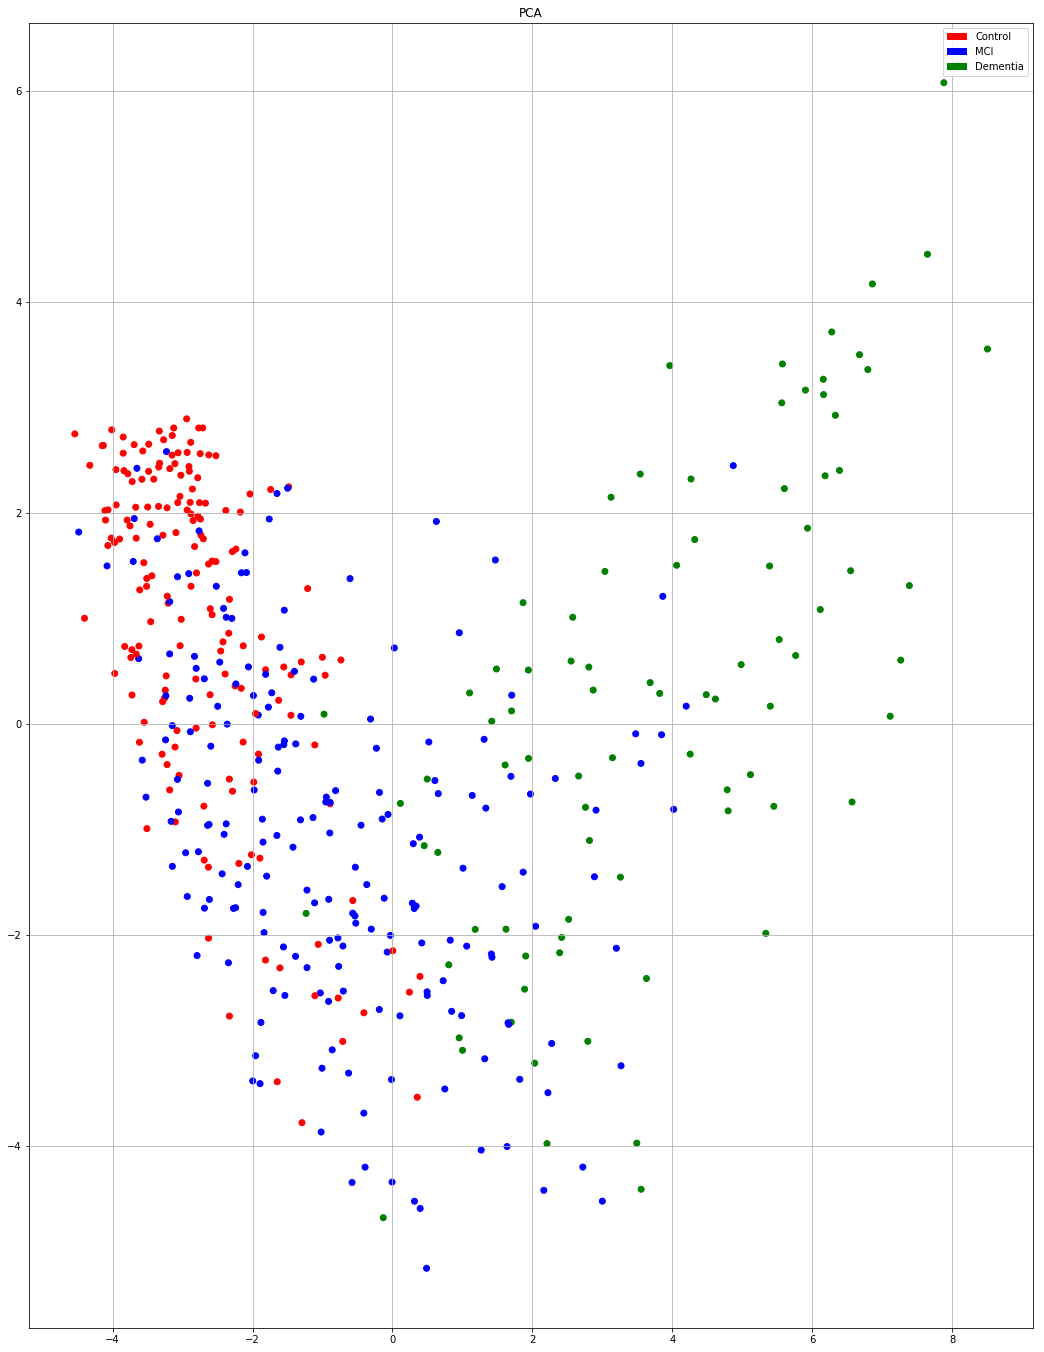

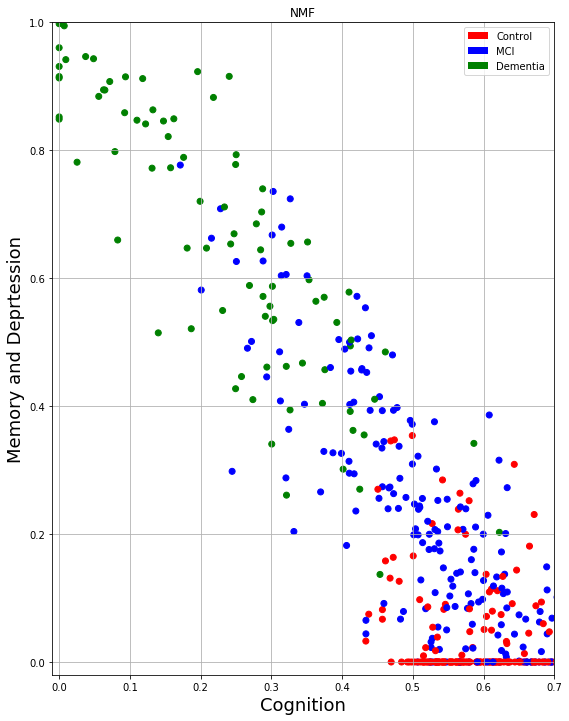

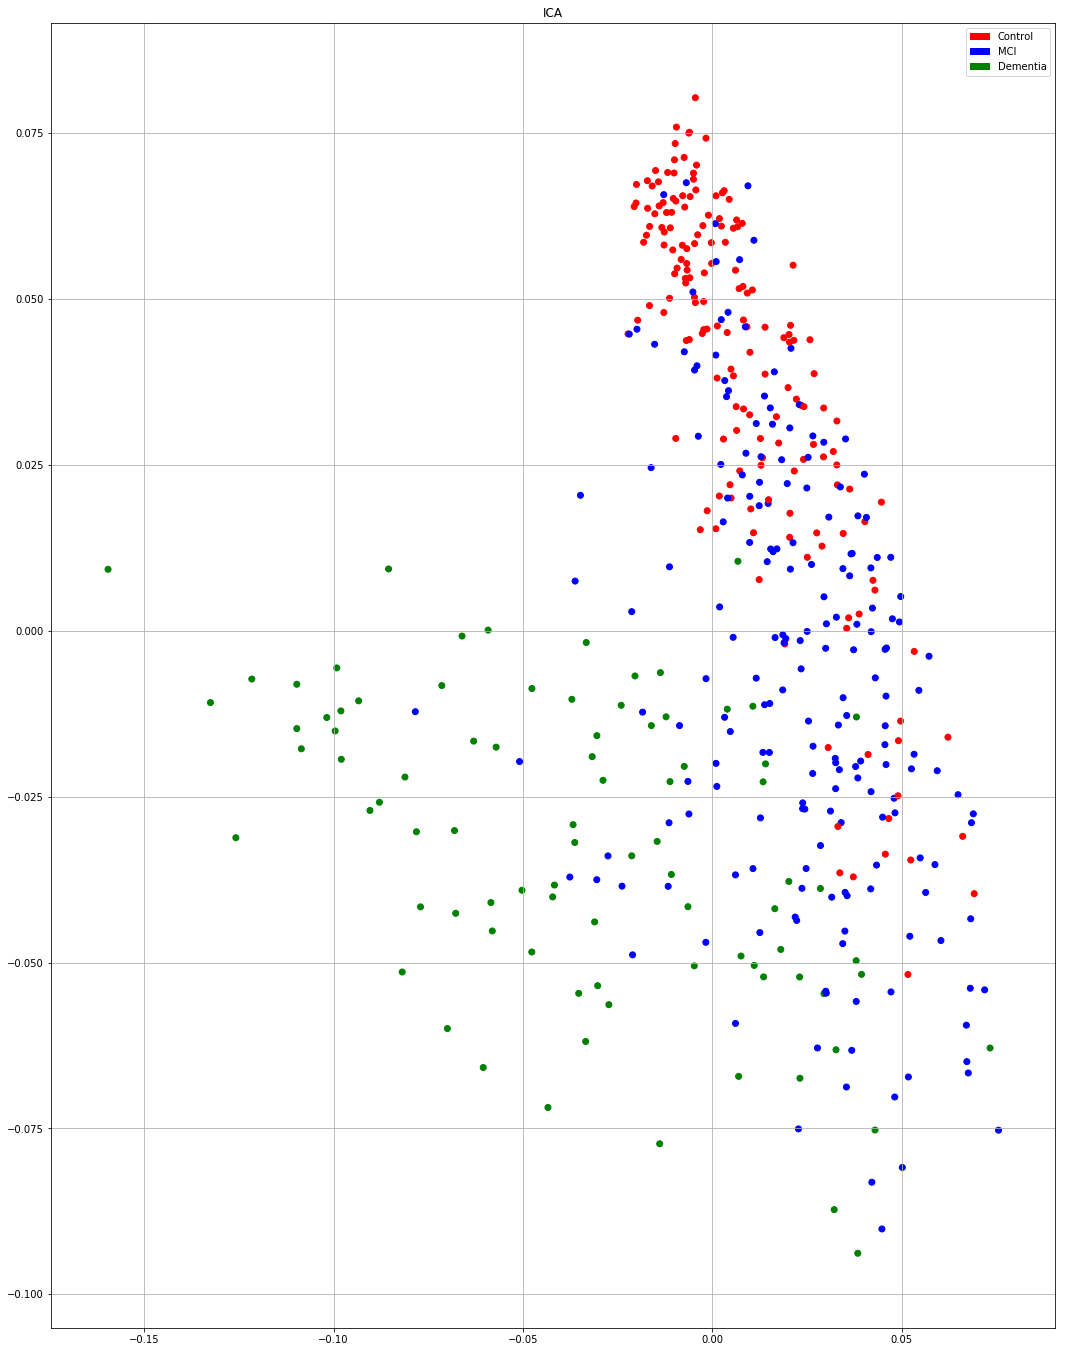

In [62]:
projections(redued_item_24,colors_categories_item_24,'only_three')

## Visualizing data in 3D

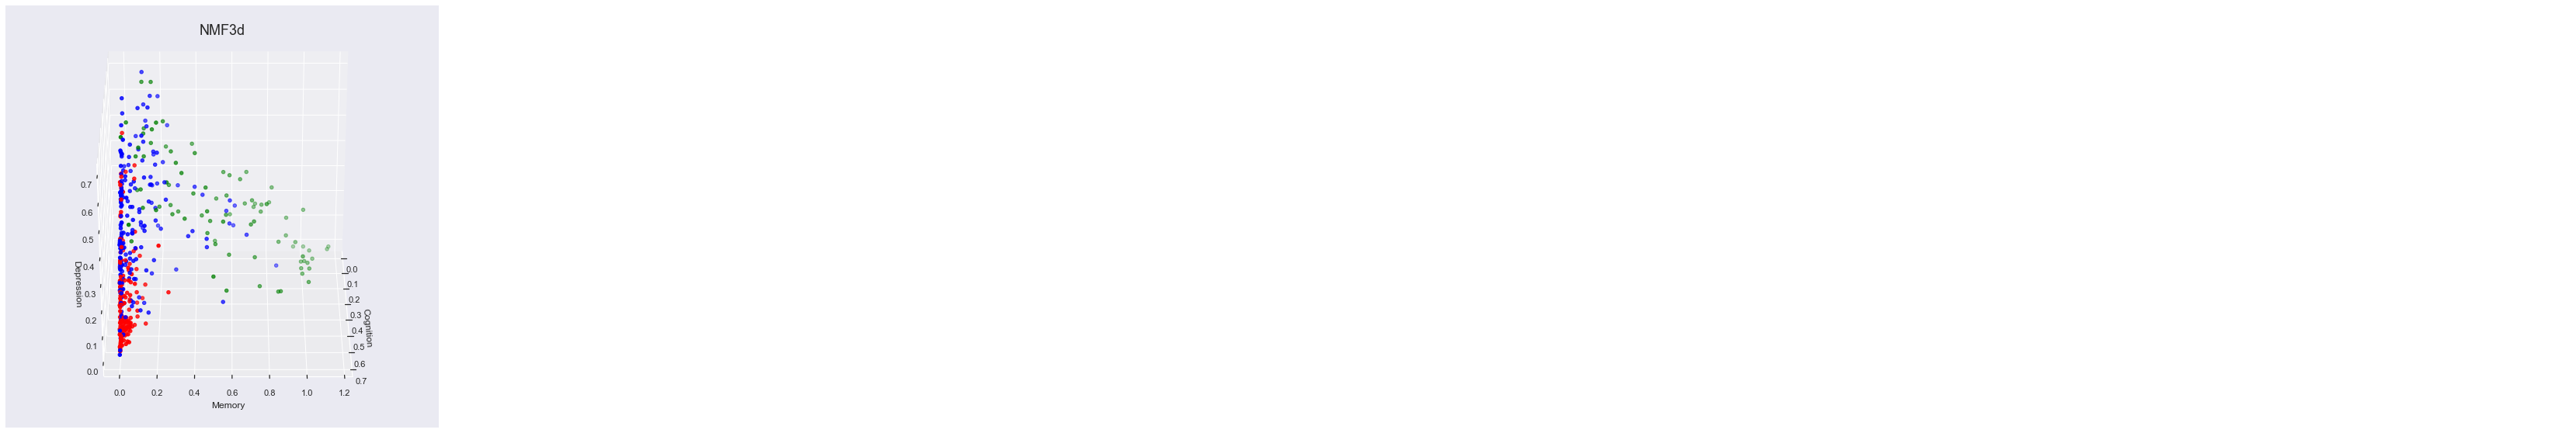

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [43]:
PCA_NMF_ICA_projections_3d(redued_item_24,colors_categories_item_24,'yes','no','no')

## Converting 3D data ito gif for better visualization.

In [74]:
gif_convert()

## Below code uses GMM to find the clusters. The function organize_prediction_moca() is used to organize lable withthe colors.
#### Note these are the color code followed 0 - 'yellow' - 'low ',  1 - 'hotpink' - 'medium' , 2 - 'blue' - 'high' , 3 - controls - 'red'.

1    143
2     91
0     48
Name: 0, dtype: int64
3.0    170
1.0    143
2.0     91
0.0     48
Name: predicted, dtype: int64


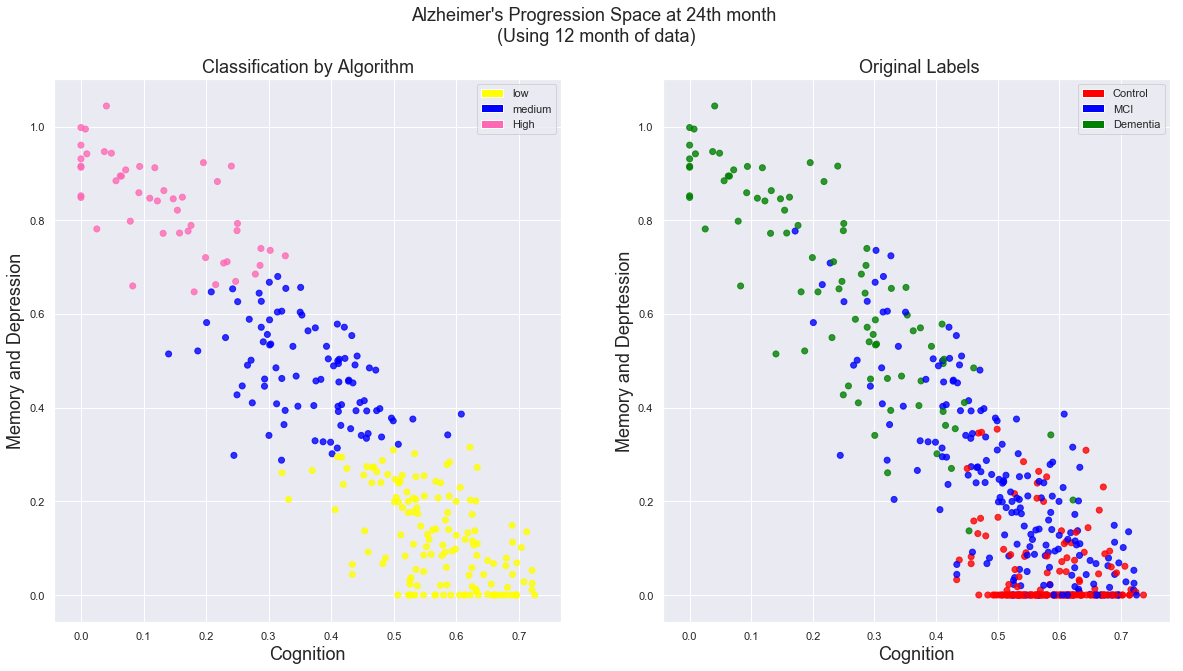

<Figure size 1080x1440 with 0 Axes>

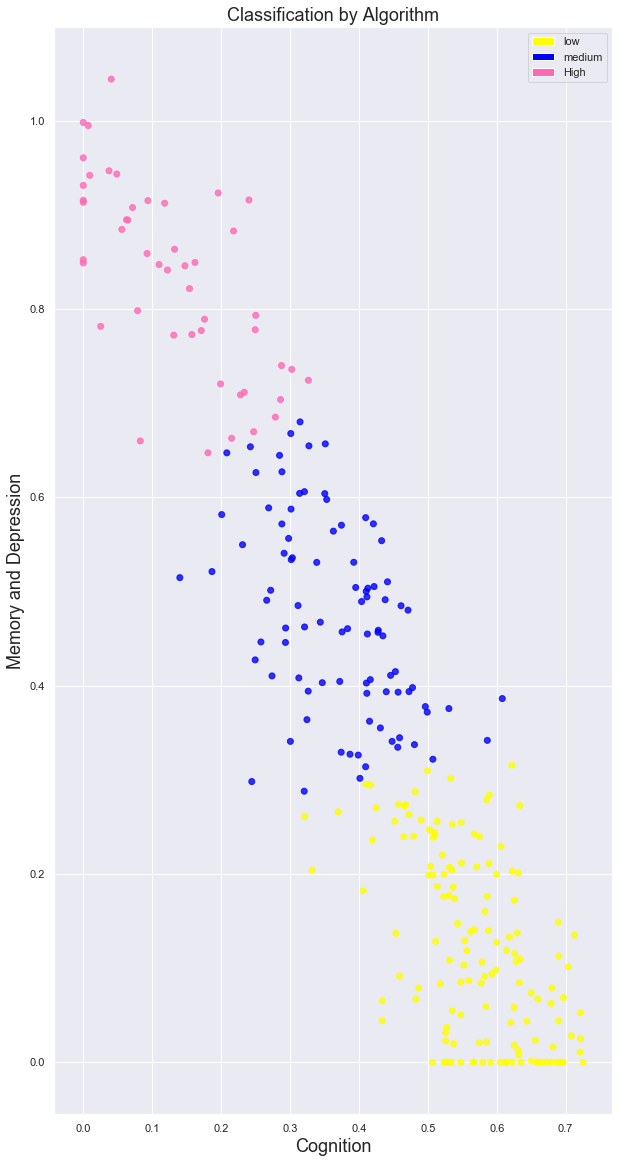

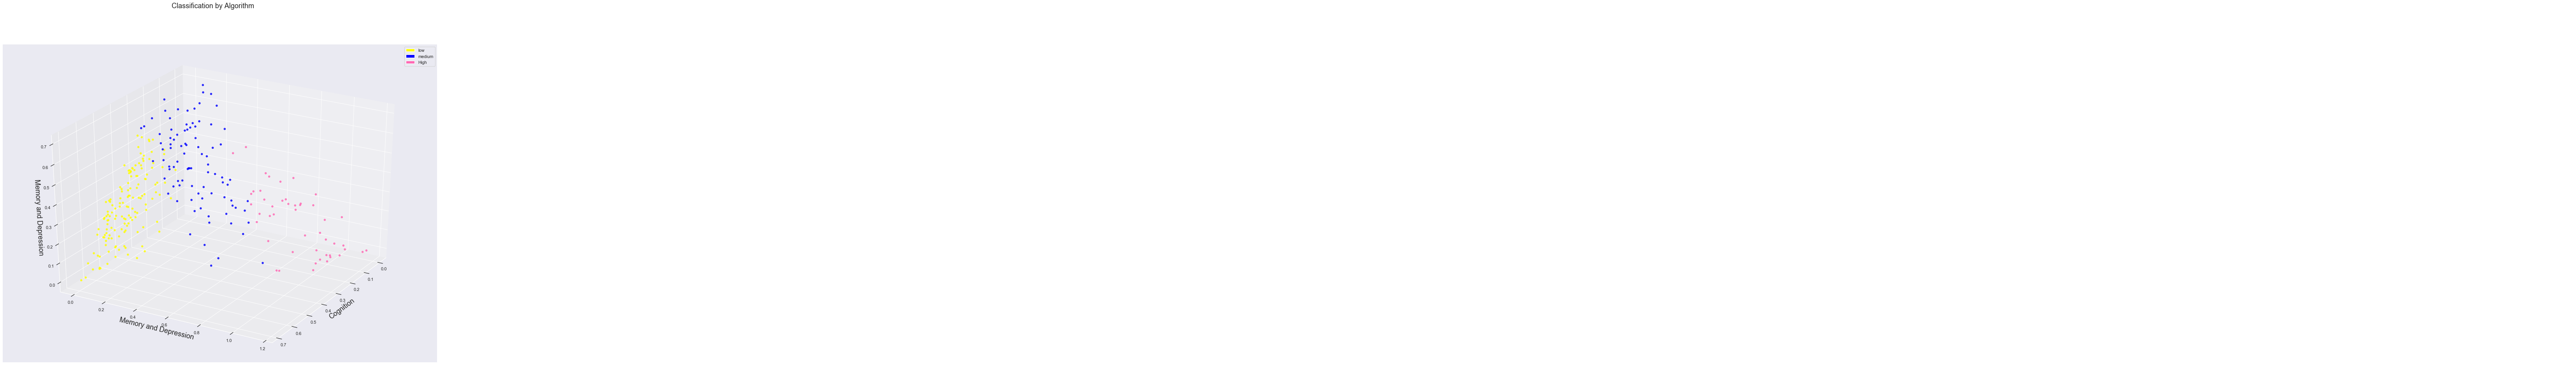

In [45]:
M_mci_dem = redued_item_24
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2','NMF_3_1', 'NMF_3_2','NMF_3_3']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(redued_item_24.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj_3d_only = M_mci_dem_nmf_proj_all[['NMF_3_1','NMF_3_2','NMF_3_3']]
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]

try:
    colors_categories_item_24_no_controls = redued_item_24[~(redued_item_24.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort_values([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)



from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='tied',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
print(Predict_gmm.iloc[:,0].value_counts())

Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = organize_prediction_moca(M_mci_dem_nmf_proj,Predict_gmm)

plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')       
plot_side_by_side_3d(M_mci_dem_nmf_proj_3d_only,Predict_gmm,redued_item_24,colors_categories_item_24,'item24','gmm')       
 

# line below will convert 4 classes into 3 classes
# Predict_gmm = Predict_gmm.replace([1,2],[1,1])
nl_data = M_mci_dem_nmf[(redued_item_24.DXCHANGE.isin([1]) )]
data_prediction_labels = pd.concat([nl_data,M_mci_dem_nmf_proj]).fillna(3)
print(data_prediction_labels.iloc[:,-1].value_counts())

data_prediction = pd.merge(M_chosen_item_24,pd.DataFrame(data_prediction_labels['predicted']),left_index = True, right_index = True, how='inner')

#[0,1,2,4],['yellow','blue','hotpink','cyan']

#### Verifying optimum number of clusters.Gaussian Mixture Model (GMM) for clustering

[   47.82671867  -497.56067789 -3882.39295778 -3858.52497869
 -3849.24165557 -3832.44344779 -3808.83043782]


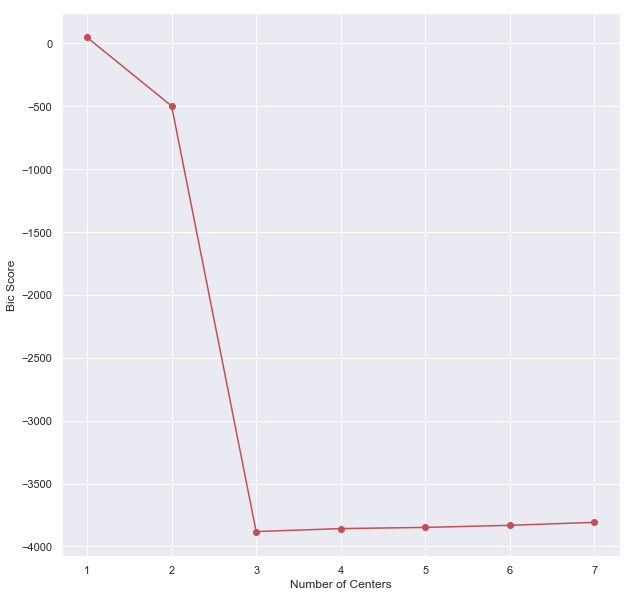

In [46]:
from sklearn import mixture
fig, ax = plt.subplots(figsize=(10, 10))
Nclusters = np.arange(1, 8)
# find best number of clusters via BIC
#clfs = [mixture.GaussianMixture(n_components=N, covariance_type='tied').fit(M_mci_dem_nmf_proj) for N in Nclusters]
clfs = [mixture.GaussianMixture(n_components=N, covariance_type='tied').fit(M_mci_dem_nmf_proj) for N in Nclusters]
BICs = np.array([clf.bic(M_mci_dem_nmf_proj) for clf in clfs])
clf = clfs[np.argmin(BICs)]
print(BICs)
# scatter the points
ax.plot(Nclusters, BICs, 'ro-')
plt.savefig(address + 'bic_48.png',dpi = 200)  
plt.xlabel('Number of Centers')
plt.ylabel('Bic Score')
plt.show()

## Following finction visualizes the clusters in the original labels.

ValueError: color kwarg must have one color per data set. 1 data sets and 196 colors were provided

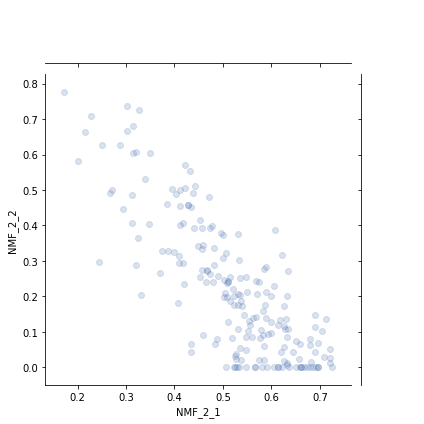

In [47]:
colors_categories_item_24 = pd.DataFrame(colors_categories_item_24)

import matplotlib as mpl
mpl.style.use('default')
%matplotlib inline

x_blue = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['blue']),'NMF_2_1']
y_blue = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['blue']),'NMF_2_2']

x_red = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['red']),'NMF_2_1']
y_red = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['red']),'NMF_2_2']

x_green = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['green']),'NMF_2_1']
y_green = redued_item_24.loc[colors_categories_item_24.DXCHANGE.isin(['green']),'NMF_2_2']


plt.ion()
plt.show()
plt.pause(0.001)
a = 0.2
l = 10
zo = 0

p = sns.JointGrid(x = x_blue, y = y_blue)
p = p.plot_joint(plt.scatter, c="b", alpha = a)
# p.ax_marg_x.hist(-x_hc, alpha = 0.5, color='r')
# p.ax_marg_y.hist(y_hc, orientation = 'horizontal', alpha = 0.5, color='r')
p.plot_marginals(sns.distplot, color='b', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

p.x = x_red
p.y = y_red
p.plot_joint(plt.scatter, c="r", alpha = a)
p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")

p.x = x_green
p.y = y_green
p.plot_joint(plt.scatter, c="g", alpha = a)
p.plot_marginals(sns.distplot, color='g', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")


p.set_axis_labels(xlabel='Cognition', ylabel='Memory and Depression')
p.ax_joint.set_xticklabels([])
p.ax_joint.set_yticklabels([])
# p.ax_marg_x.legend_.remove()

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
plt.legend((p1, p2, p3), ('Controls', 'MCI', 'Dementia'), loc='best',prop={'size':12});
plt.savefig(address + 'gmm_original_joint_plot.png',dpi = 200)

## Following finction visualizes the new clusters.

In [95]:
colors_categories_item_24 = pd.DataFrame(colors_categories_item_24)

import matplotlib as mpl
mpl.style.use('default')
%matplotlib inline

x_red = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([0]),'NMF_2_1']
y_red = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([0]),'NMF_2_2']

x_blue = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([1]),'NMF_2_1']
y_blue = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([1]),'NMF_2_2']

x_green = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([2]),'NMF_2_1']
y_green = M_mci_dem_nmf_proj.loc[Predict_gmm.iloc[:,0].isin([2]),'NMF_2_2']
plt.ion()
plt.show()
plt.pause(0.001)
a = 0.2
l = 10
zo = 0



ValueError: color kwarg must have one color per data set. 1 data sets and 91 colors were provided

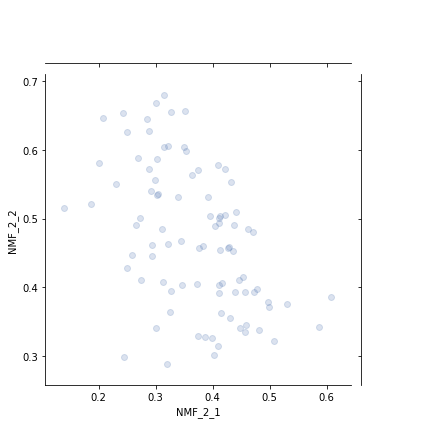

In [110]:
p = sns.JointGrid(x = x_blue, y = y_blue)
p = p.plot_joint(plt.scatter, c='b', alpha = a)

#p.ax_marg_x.hist(-x_hc, alpha = 0.5, color='r')
#p.ax_marg_y.hist(y_hc, orientation = 'horizontal', alpha = 0.5, color='r')
p.plot_marginals(sns.distplot)
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")




In [104]:
sns.distplot

<function seaborn.distributions.distplot>

In [ ]:
p.x = x_red
p.y = y_red
p.plot_joint(plt.scatter, c="r", alpha = a)
p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")

p.x = x_green
p.y = y_green
p.plot_joint(plt.scatter, c="g", alpha = a)
p.plot_marginals(sns.distplot, color='g', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Greens")


p.set_axis_labels(xlabel='Cognition', ylabel='Memory and Depression')
p.ax_joint.set_xticklabels([])
p.ax_joint.set_yticklabels([])
# p.ax_marg_x.legend_.remove()

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
plt.legend((p1, p2, p3), ('Low', 'Medium', 'High'), loc='best',prop={'size':12});
plt.savefig(address + 'gmm_predicted_joint_plot.png',dpi = 200)

# Below is the code for predicting the progression.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.cross_validation import train_test_split
# from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
h = .02  # step size in the mesh
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

### Comparision of classifiers

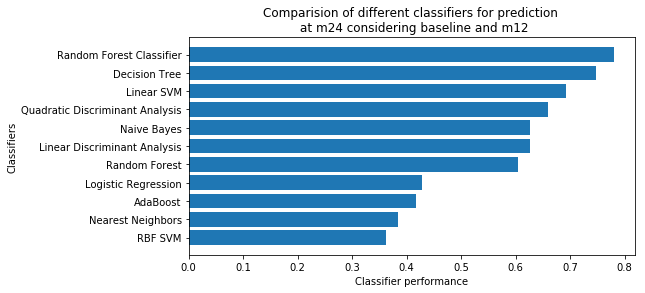

In [52]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis", "Logistic Regression"
         , "Random Forest Classifier"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    LogisticRegression(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(n_estimators = 40)]

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# considering low mci and control same 
data_prediction1 = data_prediction.copy(deep = True)
data_prediction1['predicted'] = data_prediction1['predicted'].replace([3],[3])
del data_prediction1['predicted'] 

Predict_gmm = Predict_gmm.rename(columns={0: "predicted"})
data_prediction1 = pd.merge(data_prediction1,Predict_gmm,left_index = True, right_index = True, how='outer')
data_prediction1 = data_prediction1.fillna(3)

X_train, X_test, y_train, y_test = train_test_split(data_prediction1.iloc[:,0:-1], data_prediction1['predicted'], test_size=0.2, random_state=42)

x_full = data_prediction1.iloc[:,0:-1]
y_full = data_prediction1['predicted']


scores1 = []
score_entry = {}
y_pred = {}

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score1 = clf.score(X_test, y_test)
    y_pred[name] = (clf.predict(X_test))
    scores1.append(score1)
    score_entry[name] = score1
  
    
# figure = plt.figure(figsize=(27, 9))
plt.figure(2, figsize=(8, 4))
imp, names = zip(*sorted(zip(scores1, names)))
plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)
plt.xlabel('Classifier performance')
plt.ylabel('Classifiers')
plt.title('Comparision of different classifiers for prediction \n at m24 considering baseline and m12')
plt.savefig(address + 'm48_m12_comparison.png',dpi = 200)
plt.show()

### Fine tuning Random Forest

In [37]:
pipeline = Pipeline([('classifier', RandomForestClassifier())])
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)
mean = scores.mean()
std = scores.std()
print('Mean of the five fold cross validation accuracy = ', mean)
print('Standard Deviation of the five fold cross validation accuracy = ',std)
print(pipeline.get_params())

'''
you can also specify classifications models here
'''
grid = {
    'classifier__n_estimators': [5,10,15,20,25,30,35,40,45,50],\
    'classifier__max_depth' : [5,10,15,20,25,30,35,40,45,50],\
    'classifier__class_weight': [None, 'balanced'],\
    'classifier__max_features': ['auto','sqrt','log2', None],\
    'classifier__random_state' : [0],  
    'classifier__min_samples_leaf':[1,2,3,0.1,0.05,0.01]
}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=1, cv=5)
grid_search.fit(X=x_full, y=y_full)

print("-----------")
print("-----------")
print('best score\n')
print(grid_search.best_score_)
print('best_params\n')
print(grid_search.best_params_)
print(grid_search.best_index_)
print('Mean cv accuracy on test set\n')
print(grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
print('Standard deviation on test set\n')
print(grid_search.cv_results_['std_test_score'][grid_search.best_index_])
print('Mean cv accuracy on train set\n')
print(grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
print('Standard deviation on train set\n')
print(grid_search.cv_results_['std_train_score'][grid_search.best_index_])
print(grid_search.best_score_)


Mean of the five fold cross validation accuracy =  0.714686006946281
Standard Deviation of the five fold cross validation accuracy =  0.07840755606539582
{'classifier__n_jobs': 1, 'classifier__max_leaf_nodes': None, 'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'classifier__max_features': 'auto', 'classifier__bootstrap': True, 'classifier__criterion': 'gini', 'steps': [('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            m

## Evaluation Metrics

### PLoting Confusion Metrics

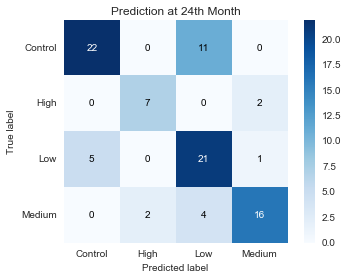

accuracy on test is
0.7252747252747253


In [75]:
#y_train = y_train.replace([1,2,3],['High MCI+Low Dementia', 'High Dementia', 'low MCI + control'])
rf = RandomForestClassifier(max_features= 'auto', n_estimators=35, max_depth= 20,class_weight= 'balanced', random_state= 0, min_samples_leaf =2)
rf.fit(X_train, y_train)
predictions  = rf.predict_proba(X_test)

y_predicted = rf.predict(X_test)
s = y_test.replace([1,2,0,3],['Medium', 'High', 'Low','Control'])
c = pd.DataFrame(y_predicted).replace([1,2,0,3],['Medium', 'High', 'Low','Control'])
skplt.metrics.plot_confusion_matrix(s,c, title = 'Prediction at 24th Month')
plt.savefig(address + 'confusion_matrix_24.png',dpi = 200)
plt.show()

score_on_test = accuracy_score(y_test, y_predicted)
print('accuracy on test is')
print(score_on_test)
# new cv accuracy
# pipeline1 = Pipeline([('classifier', rf )])
# scores_new = cross_val_score(pipeline1, X_train, y_train, scoring='accuracy', cv=5)
# mean_new = scores_new.mean()
# std_new = scores_new.std()
# print('Mean of the five fold cross validation accuracy = ', mean_new)
# print('Standard Deviation of the five fold cross validation accuracy = ',std_new)

## Ploting Roc curve and Calculating Area under ROC

In [76]:

# considering low mci and control same 
data_prediction1 = data_prediction.copy(deep = True)
data_prediction1['predicted'] = data_prediction1['predicted'].replace([3],[3])
del data_prediction1['predicted'] 

Predict_gmm = Predict_gmm.rename(columns={0: "predicted"})
data_prediction1 = pd.merge(data_prediction1,Predict_gmm,left_index = True, right_index = True, how='outer')
data_prediction1 = data_prediction1.fillna(3)

# X_train, X_test, y_train, y_test = train_test_split(data_prediction1.iloc[:,0:-1], data_prediction1['predicted'], test_size=0.2, random_state=42)


classes = y_train.unique()
for no_class in classes:
    #rf = RandomForestClassifier(max_features= None, n_estimators=45, max_depth= 15,class_weight= None, random_state= 0)
    #rf.fit(X_train1, y_train==no_class)
    #predictions  = rf.predict_proba(X_test)
    #print (predictions)
    #y_true = (y_test==no_class) # ground truth labels
    #y_probas = predictions# predicted probabilities generated by sklearn classifier
    scores_auc = cross_val_score(pipeline, X_train, y_train==no_class, scoring='roc_auc', cv=5)
    #print (sklearn.metrics.roc_auc_score(y_true, y_probas[:,1]))
    print ('Average and SD of AUC Scores for class =',  no_class, ':', scores_auc.mean(), scores_auc.std())

Average and SD of AUC Scores for class = 3.0 : 0.9385137085137085 0.04318810911365354
Average and SD of AUC Scores for class = 0.0 : 0.8758281573498966 0.0547838255696001
Average and SD of AUC Scores for class = 2.0 : 0.977596153846154 0.015965568309529013
Average and SD of AUC Scores for class = 1.0 : 0.8926879082343723 0.0610601625539179


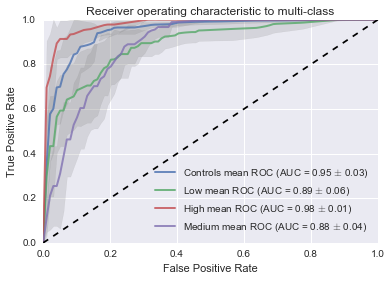

In [77]:
# 5 fold cv
from sklearn import metrics 
X,Y = data_prediction1.iloc[:,0:-1],data_prediction1['predicted']
n_classes = y_train.unique()
cv = StratifiedKFold(n_splits=5)
for k in n_classes:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in cv.split(X,Y):
            pipeline = Pipeline([('classifier', RandomForestClassifier(max_features= None, n_estimators=35, max_depth= 10,class_weight= 'balanced', random_state= 0))])
            pipeline.fit(X.iloc[train], Y.iloc[train]==k)
            preds  = pipeline.predict_proba(X.iloc[test])
            label =  Y.iloc[test] == k
            fpr, tpr, _ = metrics.roc_curve(label, preds[:,1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = metrics.auc(fpr, tpr)
            aucs.append(roc_auc)
            i += 1
            
    class_name = 'Controls' if k==3 else 'Low' if k==0 else 'Medium' if k==1 else 'High'
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr,label= r'{0} mean ROC (AUC = {1:0.2f} $\pm$ {2:0.2f})'.format(class_name, mean_auc, std_auc) ,lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)
    #print(mean_fpr- tprs_upper)
    #print(std_tpr)


plt.figure(1, figsize=(20, 20))
plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.025, 1.025])
# plt.ylim([-0.025, 1.025])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig(address + 'Roc_m24_12.png',dpi = 200)
plt.show()



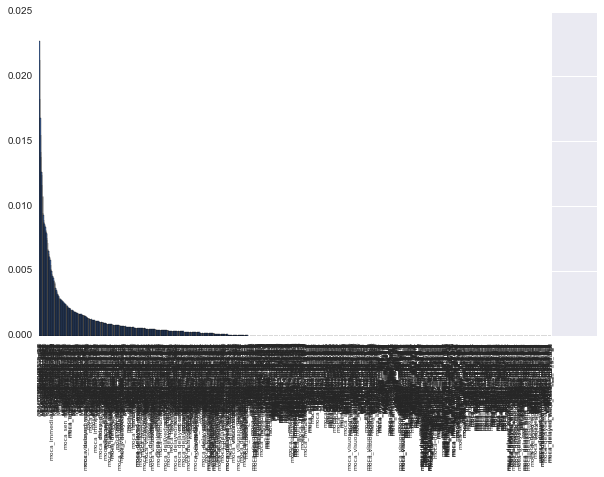

In [78]:
g = pd.DataFrame(np.empty((X_train.shape[1],2)))
ada = rf
ada.fit(X_train, y_train)
g.iloc[:,0] = (X_train.columns)
g.iloc[:,1] = ada.feature_importances_  
g = g.sort_values(by=[1],ascending=False)
plt.figure(figsize=(10,10))
plt.gcf().subplots_adjust(bottom=0.45)
plt.bar(range(g.shape[0]),g.iloc[:,1])
plt.xticks(range(len(g)),g.iloc[:,0] ,rotation=90)
plt.tick_params(axis='x', which='major', labelsize=6 )
plt.show()

In [79]:
g.head(200)

,0,1
788,MEMORY4___m12_4.0_x,0.022711
1711,CDMEMORY___m12,0.021270
1714,CDJUDGE___m06,0.018249
1804,"('FAQTOTAL', 'm12')_0.0",0.016804
1237,ADNI_MEM___bl,0.015456
1008,VISSPAT4___m12_4.0_x,0.014140
1718,CDHOME___m06,0.013774
1715,CDJUDGE___m12,0.012647
553,AVTOT6___bl,0.012646
549,AVTOT5___m12,0.012370


In [53]:
#VISUALISATIONS 
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])

#The patient who visited again and again in different VISCODES, keeping only the first visit
adni_merge = adni_merge.groupby(adni_merge.index).min()
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_item_24.index)] #CHANGE HERE FOR DIFFERENT DATASETS 

In [54]:
result = pd.concat([adni_merge_chosen, redued_item_24] , axis = 1, ignore_index= False)

In [55]:
result.head()

,VISCODE,COLPROT,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,PCA_1,PCA_2,...,NMF_3_1,NMF_3_2,NMF_3_3,ICA_3_1,ICA_3_2,ICA_3_3,VISCODE,DXMDUE,DXCHANGE,DXCONFID
RID,,,,,,,,,,,,,,,,,,,,,
4003,bl,ADNI2,72.3,Female,16,Unknown,White,Married,-3.03604,2.1578,...,0.537756,0.0187505,0,-0.0583365,-0.0061907,-0.00485713,m24,NaN,1,NaN
4004,bl,ADNI2,66.8,Female,14,Not Hisp/Latino,White,Divorced,-2.24073,-1.74046,...,0.524053,0,0.322171,0.00664412,0.0319938,-0.0433281,m24,MCI due to Alzheimer's Disease,2,NaN
4005,bl,ADNI2,70.5,Male,16,Not Hisp/Latino,White,Married,1.62101,-1.94411,...,0.241553,0.241626,0.397602,0.0421432,0.0220739,0.0197498,m24,NaN,3,NaN
4007,bl,ADNI2,78.1,Male,20,Not Hisp/Latino,White,Married,-1.54481,-0.159682,...,0.431682,0.0459769,0.213417,-0.0123512,0.0282661,0.0290251,m24,MCI due to Alzheimer's Disease,2,NaN
4009,bl,ADNI2,90.3,Male,17,Hisp/Latino,White,Married,6.1802,2.35289,...,0.0552127,0.90886,0.0789305,0.0198529,-0.0822805,0.0352108,m24,NaN,3,NaN


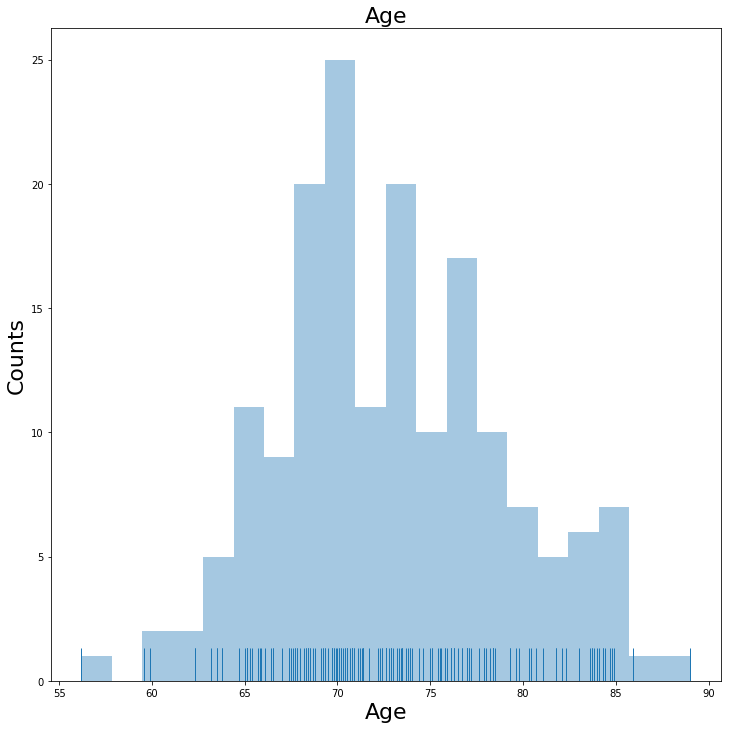

72.8929411764706
6.068607518653207


In [56]:
result_control = result[result['DXCHANGE']==1] #Plotting only for a particular visit code
plt.figure(figsize = (12, 12))
sns.distplot(result_control['AGE'], bins=20, kde=False, rug=True);
plt.xlabel('Age', fontsize = 22)
plt.title('Age', fontsize = 22)
plt.ylabel('Counts', fontsize = 22)
plt.show()
print(result_control['AGE'].mean())
print(result_control['AGE'].std())


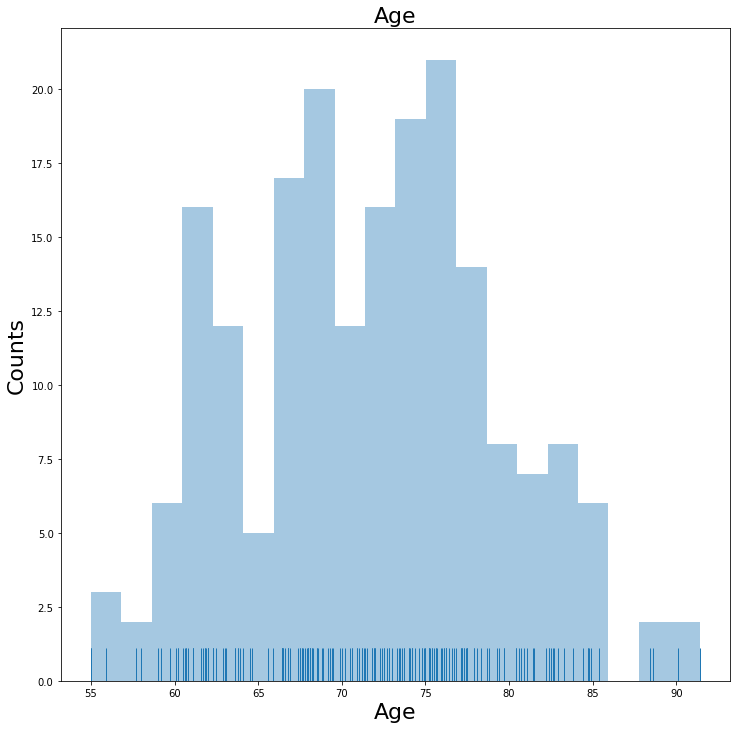

71.6163265306123
7.490071293044031


In [57]:
result_control = result[result['DXCHANGE']==2] #Plotting only for a particular visit code
plt.figure(figsize = (12, 12))
sns.distplot(result_control['AGE'], bins=20, kde=False, rug=True);
plt.xlabel('Age', fontsize = 22)
plt.title('Age', fontsize = 22)
plt.ylabel('Counts', fontsize = 22)
plt.show()
print(result_control['AGE'].mean())
print(result_control['AGE'].std())

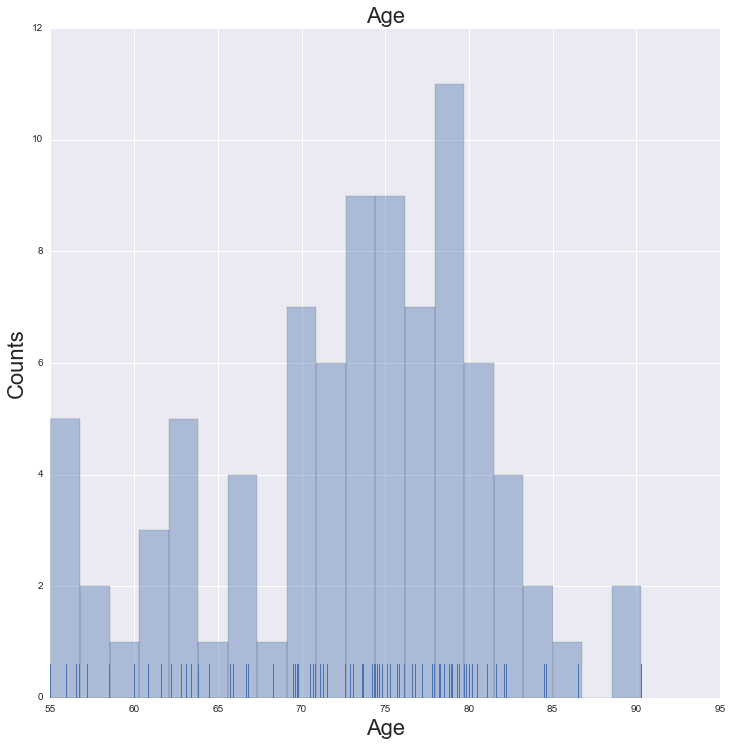

72.92325581395352
8.115238743450563


In [35]:
result_control = result[result['DXCHANGE']==3] #Plotting only for a particular visit code
plt.figure(figsize = (12, 12))
sns.distplot(result_control['AGE'], bins=20, kde=False, rug=True);
plt.xlabel('Age', fontsize = 22)
plt.title('Age', fontsize = 22)
plt.ylabel('Counts', fontsize = 22)
plt.show()
print(result_control['AGE'].mean())
print(result_control['AGE'].std())

In [36]:
result.head()

,VISCODE,COLPROT,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,PCA_1,PCA_2,...,NMF_3_1,NMF_3_2,NMF_3_3,ICA_3_1,ICA_3_2,ICA_3_3,VISCODE,DXMDUE,DXCHANGE,DXCONFID
RID,,,,,,,,,,,,,,,,,,,,,
4003,bl,ADNI2,72.3,Female,16,Unknown,White,Married,-3.03604,2.15783,...,0.537756,0.0187505,0,-0.0314266,0.0493832,0.00622387,m24,NaN,1,NaN
4004,bl,ADNI2,66.8,Female,14,Not Hisp/Latino,White,Divorced,-2.24073,-1.74047,...,0.524053,0,0.322171,0.0407955,0.0219282,-0.0282834,m24,MCI due to Alzheimer's Disease,2,NaN
4005,bl,ADNI2,70.5,Male,16,Not Hisp/Latino,White,Married,1.62101,-1.94408,...,0.241553,0.241626,0.397601,0.0109551,-0.0445762,-0.0233732,m24,NaN,3,NaN
4007,bl,ADNI2,78.1,Male,20,Not Hisp/Latino,White,Married,-1.54481,-0.159639,...,0.431682,0.0459769,0.213417,-0.0286011,-0.00614866,-0.0306293,m24,MCI due to Alzheimer's Disease,2,NaN
4009,bl,ADNI2,90.3,Male,17,Hisp/Latino,White,Married,6.1802,2.35294,...,0.0552127,0.90886,0.0789304,-0.0219636,-0.0405627,0.079223,m24,NaN,3,NaN


## Visualizing age and NMF clustering 

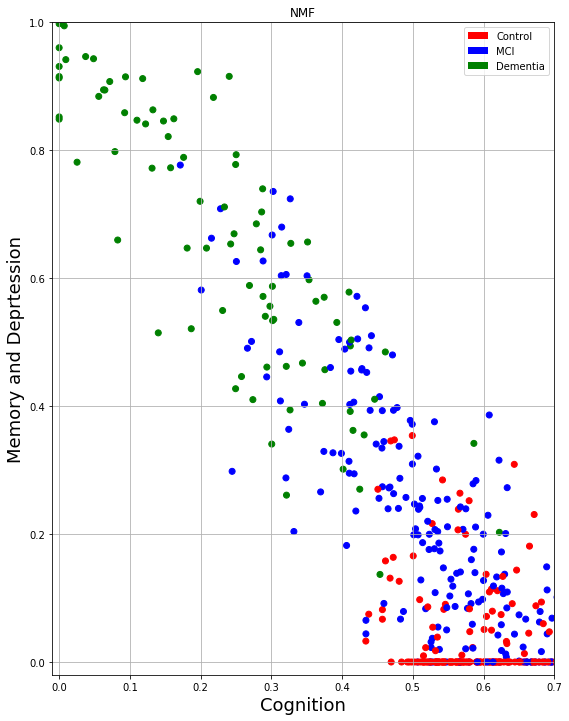

In [141]:
plt.figure(4, figsize=(9, 12))
plt.scatter(redued_item_24[['NMF_2_1']], redued_item_24[['NMF_2_2']], c = colors_categories_item_24.T.squeeze())
t = 'only-three'
plt.title('NMF')
if t == 'all':
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
    p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
    p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
    p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')
    p8 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p9 = plt.Rectangle((0, 0), 0.1, 0.1, fc='magenta')
    plt.legend((p1, p2, p3, p4, p5, p6, p7,p8,p9), ('Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'), loc='best');
else:
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    #p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    #p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    #plt.legend((p1, p2, p3), ('Control', 'MCI', 'Dementia'), loc='best');    
    plt.legend((p1, p2, p3), ('Control', 'MCI', 'Dementia'), loc='best');    
plt.xlim((-.01, 0.7))
plt.ylim((-.02, 1.0)) 
plt.xlabel('Cognition', fontsize = 18)
plt.ylabel('Memory and Deprtession', fontsize = 18)
plt.title('NMF')
plt.grid(True)
plt.savefig(address + 'nmf_prog.png',dpi = 200)
plt.show()

In [393]:
c =  colors_categories_item_24.T.squeeze()
#NMF and age distinction for controls 
controls_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='red']
#controls_nmf['Age'] = result['AGE'][controls_nmf.index] #Way 1 
controls_nmf['predicted'] = 0 #Way 2
controls_nmf['predicted'][result['AGE']>70] = 1

#NMF and age distinction for MCI
mci_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='blue']
mci_nmf ['Age'] = result['AGE'][mci_nmf.index] #Way 1 
#mci_nmf['predicted'] = 0 #Way 2
#mci_nmf['predicted'][result['AGE']>75] = 1

#NMF and age distinction for Dimentia
dimentia_nmf = redued_item_24[['NMF_2_1','NMF_2_2']].loc[c=='green']
dimentia_nmf['Age'] = result['AGE'][dimentia_nmf.index] #Way 1 
#dimentia_nmf['predicted'] = 0 #Way 2
#dimentia_nmf['predicted'][result['AGE']>75] = 1

In [394]:
#mci_nmf = mci_nmf.append(dimentia_nmf) #To combine MCI and dimentia both

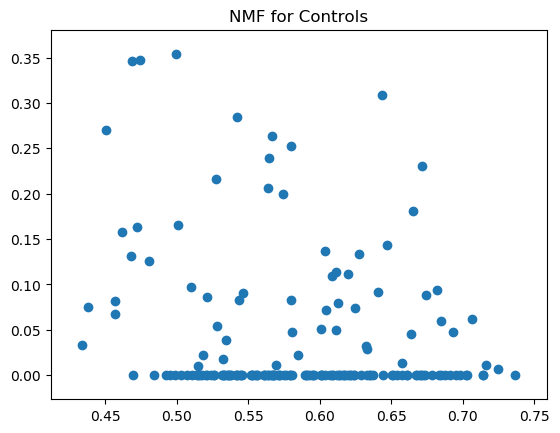

In [395]:
#NMF projection for only controls 
plt.scatter(controls_nmf.iloc[:,0], controls_nmf.iloc[:,1])
plt.title('NMF for Controls')
plt.show()

In [396]:
from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=2, covariance_type='tied',  random_state = 0)
model_gmm.fit(controls_nmf) 
Predict_gmm = pd.DataFrame(model_gmm.predict(controls_nmf))
Predict_gmm.index = controls_nmf.index

Age distribution in controls


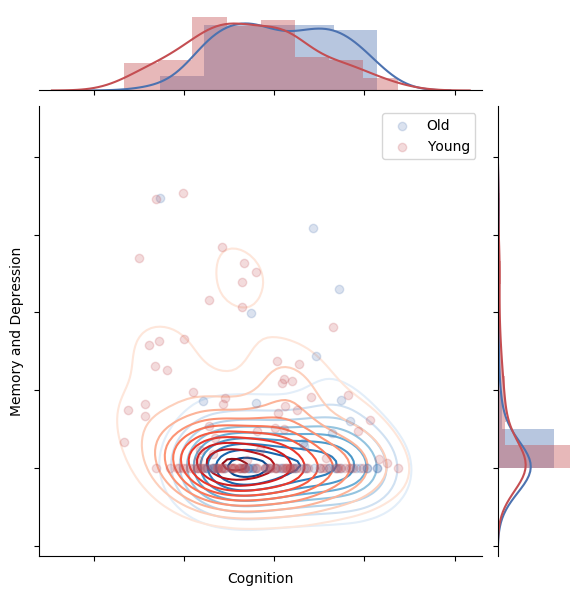

In [400]:
import seaborn as sns 
#Considering controls_nmf
x_red = list(controls_nmf[(Predict_gmm==0).values]['NMF_2_1'].values) #Less than 75
y_red = list(controls_nmf[(Predict_gmm==0).values]['NMF_2_2'].values)

x_blue = list(controls_nmf[(Predict_gmm==1).values]['NMF_2_1'].values) #Greater than 75
y_blue = list(controls_nmf[(Predict_gmm==1).values]['NMF_2_2'].values)

import matplotlib as mpl
mpl.style.use('default')

plt.ion()
plt.show()
plt.pause(0.001)
a = 0.2
l = 10
zo = 0

p = sns.JointGrid(x = x_blue, y = y_blue)
p = p.plot_joint(plt.scatter, c="b", alpha = a)

p.plot_marginals(sns.distplot, color='b', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

p.x = x_red
p.y = y_red
p.plot_joint(plt.scatter, c="r", alpha = a)
p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
plt.legend(['Old', 'Young'])

print('Age distribution in controls')
p.set_axis_labels(xlabel='Cognition', ylabel='Memory and Depression')
p.ax_joint.set_xticklabels([])
p.ax_joint.set_yticklabels([])
# p.ax_marg_x.legend_.remove()

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
#lt.legend((p1, p2), ('Young', 'Old'), loc='best',prop={'size':12});
plt.savefig(address + 'gmm_joint_plot.png',dpi = 200)

plt.show()

In [374]:
from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=2, covariance_type='tied',  random_state = 5)
model_gmm.fit(mci_nmf) 
Predict_gmm = pd.DataFrame(model_gmm.predict(mci_nmf))
Predict_gmm.index = mci_nmf.index

Age distribution in MCI


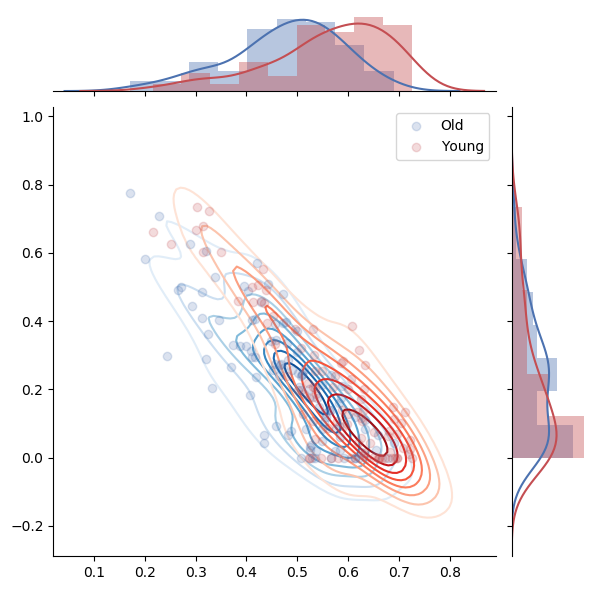

In [375]:
import seaborn as sns 
#Considering controls_nmf
x_red = list(mci_nmf[(Predict_gmm==0).values]['NMF_2_1'].values) #Less than 75
y_red = list(mci_nmf[(Predict_gmm==0).values]['NMF_2_2'].values)

x_blue = list(mci_nmf[(Predict_gmm==1).values]['NMF_2_1'].values) #Greater than 75
y_blue = list(mci_nmf[(Predict_gmm==1).values]['NMF_2_2'].values)

import matplotlib as mpl
mpl.style.use('default')

plt.ion()
plt.show()
plt.pause(0.001)
a = 0.2
l = 10
zo = 0

p = sns.JointGrid(x = x_blue, y = y_blue)
p = p.plot_joint(plt.scatter, c="b", alpha = a)

p.plot_marginals(sns.distplot, color='b', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

p.x = x_red
p.y = y_red
p.plot_joint(plt.scatter, c="r", alpha = a)
p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
plt.legend(['Old', 'Young'])

print('Age distribution in MCI')

plt.show()

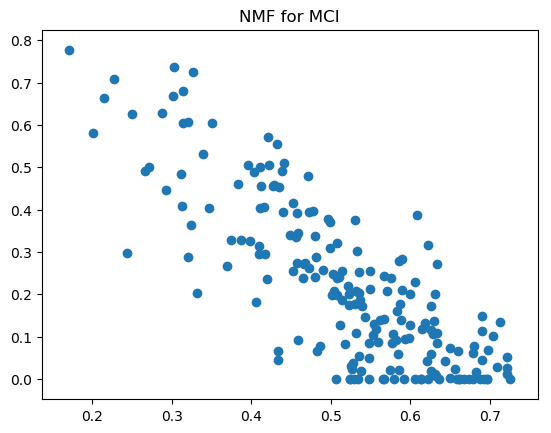

In [349]:
#NMF projection for only MCI
plt.scatter(mci_nmf.iloc[:,0], mci_nmf.iloc[:,1])
plt.title('NMF for MCI')
plt.show()


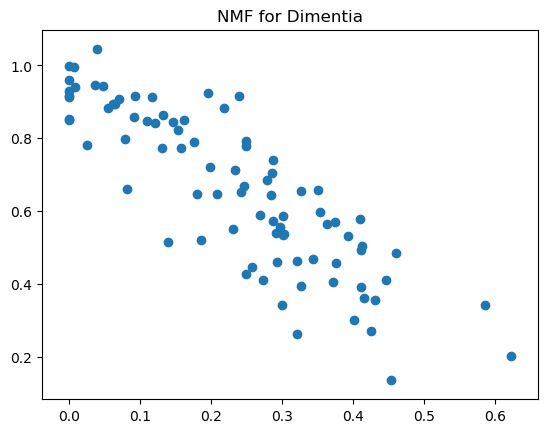

In [350]:
#NMF projection for only Dimentia
plt.scatter(dimentia_nmf.iloc[:,0], dimentia_nmf.iloc[:,1])
plt.title('NMF for Dimentia')
plt.show()

In [382]:
from sklearn import mixture
model_gmm = mixture.GaussianMixture(n_components=2, covariance_type='tied',  random_state = 0)
model_gmm.fit(dimentia_nmf) 
Predict_gmm = pd.DataFrame(model_gmm.predict(dimentia_nmf))
Predict_gmm.index = dimentia_nmf.index

Age distribution in Dimentia


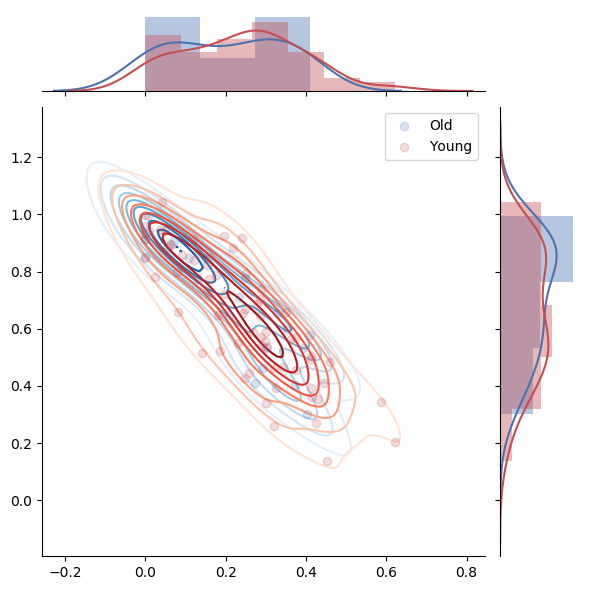

In [383]:
import seaborn as sns 
#Considering controls_nmf
x_red = list(dimentia_nmf[(Predict_gmm==0).values]['NMF_2_1'].values) #Less than 75
y_red = list(dimentia_nmf[(Predict_gmm==0).values]['NMF_2_2'].values)

x_blue = list(dimentia_nmf[(Predict_gmm==1).values]['NMF_2_1'].values) #Greater than 75
y_blue = list(dimentia_nmf[(Predict_gmm==1).values]['NMF_2_2'].values)

import matplotlib as mpl
mpl.style.use('default')

plt.ion()
plt.show()
plt.pause(0.001)
a = 0.2
l = 10
zo = 0

p = sns.JointGrid(x = x_blue, y = y_blue)
p = p.plot_joint(plt.scatter, c="b", alpha = a)

p.plot_marginals(sns.distplot, color='b', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Blues")

p.x = x_red
p.y = y_red
p.plot_joint(plt.scatter, c="r", alpha = a)
p.plot_marginals(sns.distplot, color='r', axlabel=[])
p.plot_joint(sns.kdeplot, zorder=zo, n_levels=l, cmap="Reds")
plt.legend(['Old', 'Young'])

print('Age distribution in Dimentia')
plt.show()

In [126]:
def plot_age(M_mci_dem_nmf_proj, redued_item_24, colors_categories_item_24):
    mlp.rc('font', size= 18)
    mlp.rc('axes', titlesize= 18)
    f9 = plt.figure(figsize=(20,10))
    f9.suptitle("Alzheimer's Progression Space at 24th month\n (Using 12 month of data)", fontsize = 18)
    cm = plt.cm.get_cmap('RdYlBu')
    colors =    np.array(  M_mci_dem_nmf_proj['AGE']      )
    plot = plt.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], alpha=0.5, c = colors, s = 100, cmap = cm)
    plt.xlabel('Cognition', fontsize = 18)
    plt.ylabel('Memory and Depression', fontsize = 18)
    plt.title(" Classification by Algorithm ", fontsize = 18)
    plt.colorbar(plot)
    plt.show()
    
    


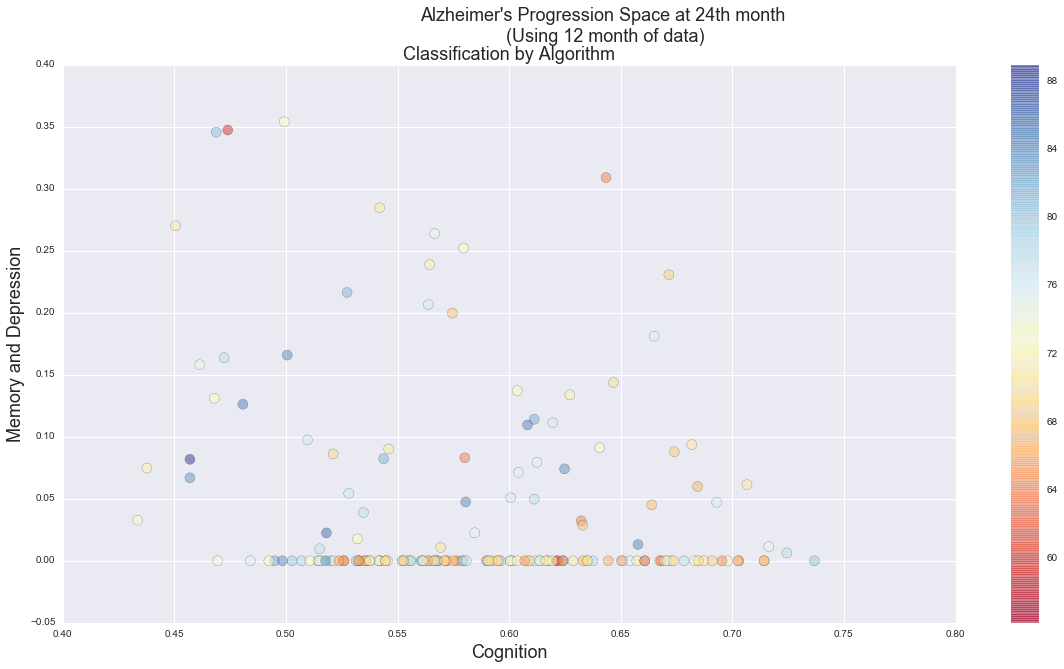

In [127]:
result_control = result[result['DXCHANGE']==1]

plot_age(result_control, redued_item_24, colors_categories_item_24)

In [150]:
def plot_age3(M_mci_dem_nmf_proj, redued_item_24, colors_categories_item_24):
    f9 = plt.figure(figsize=(20,10))
    ax= plt.axes(projection='3d')
    cm = plt.cm.get_cmap('RdYlBu')
    colors =    np.array(  M_mci_dem_nmf_proj['AGE']      )
    plot = ax.scatter(M_mci_dem_nmf_proj[['NMF_3_1']], M_mci_dem_nmf_proj[['NMF_3_2']],M_mci_dem_nmf_proj[['NMF_3_3']] , alpha=0.5, c = colors, s = 50, cmap = cm)
    ax.set_xlabel('Cognition', fontsize = 18)
    ax.set_ylabel('Memory and Depression', fontsize = 18)
    ax.set_zlabel(' Depression', fontsize = 18)
    ax.set_title(" Classification by Algorithm ", fontsize = 18)
    plt.colorbar(plot)
    ax.view_init(30,30)
    plt.show()
    

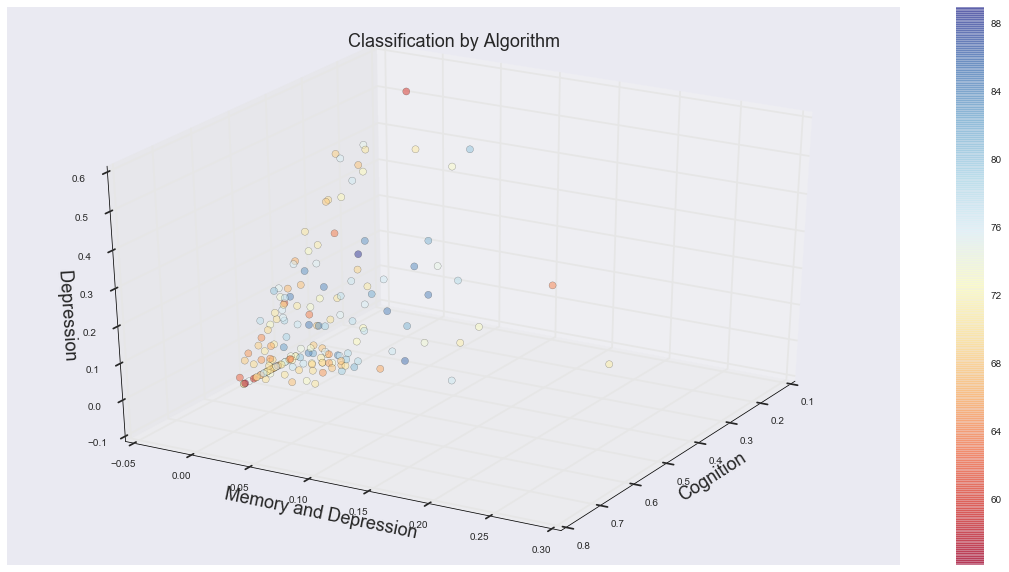

In [151]:
result_control = result[result['DXCHANGE']==1]
%matplotlib inline
plot_age3(result_control, redued_item_24, colors_categories_item_24)

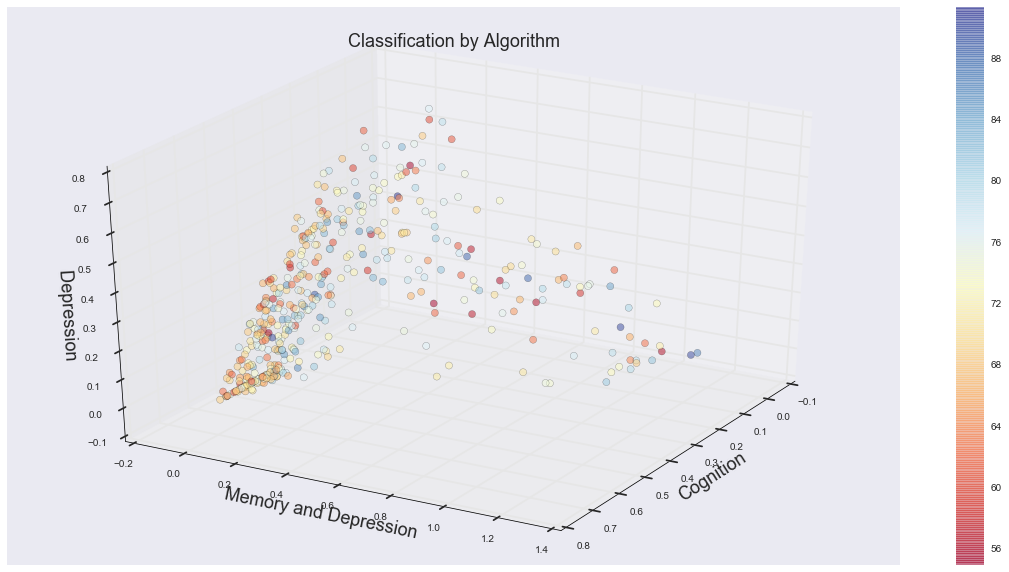

In [152]:

%matplotlib inline
plot_age3(result, redued_item_24, colors_categories_item_24)

In [ ]:

pipeline = Pipeline([('classifier', RandomForestClassifier())])
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)
mean = scores.mean()
std = scores.std()
print('Mean of the five fold cross validation accuracy = ', mean)
print('Standard Deviation of the five fold cross validation accuracy = ',std)
print(pipeline.get_params())
​
'''
you can also specify classifications models here
'''
grid = {
    'classifier__n_estimators': [5,10,15,20,25,30,35,40,45,50],\
    'classifier__max_depth' : [5,10,15,20,25,30,35,40,45,50],\
    'classifier__class_weight': [None, 'balanced'],\
    'classifier__max_features': ['auto','sqrt','log2', None],\
    'classifier__random_state' : [0],  
    'classifier__min_samples_leaf':[1,2,3,0.1,0.05,0.01]
}
​
grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=1, cv=5)
grid_search.fit(X=x_full, y=y_full)
​
print("-----------")
print("-----------")
print('best score\n')
print(grid_search.best_score_)
print('best_params\n')
print(grid_search.best_params_)
print(grid_search.best_index_)
print('Mean cv accuracy on test set\n')
print(grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
print('Standard deviation on test set\n')
print(grid_search.cv_results_['std_test_score'][grid_search.best_index_])
print('Mean cv accuracy on train set\n')
print(grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
print('Standard deviation on train set\n')
print(grid_search.cv_results_['std_train_score'][grid_search.best_index_])
print(grid_search.best_score_)









X_rfe = X.ix[:,X.columns.get_level_values(0)[rfe_fit.support_]]

# X_rfe = X_rfe.stack().reset_index().set_index('PATNO').drop('EVENT_ID',1)
X_rfe
Y_rfe = M_label_PD.GMM.replace(['HC', 'PD_l', 'PD_m', 'PD_h', 'SWEDD'], ['1', '2', '3', '4', '5'])

X_train, X_test, Y_train, Y_test = train_test_split(X_rfe, Y_rfe, test_size=0.2, random_state=42)


n_classes = len(Y_test.unique())
fpr = dict()
tpr = dict()
roc_auc = dict()

mean_tpr = dict()
mean_fpr = dict()
mean_auc = dict()

cv = StratifiedKFold(n_splits=5)
lr = LogisticRegression()

for k in range(n_classes):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in cv.split(X_rfe, Y_rfe):
        preds = lr.fit(X_rfe.iloc[train], Y_rfe.iloc[train]).predict_proba(X_rfe.iloc[test])[:,k]
        label = [1 if int(j) == (k+2) else 0 for j in Y_rfe.iloc[test]] #2,3,4
        fpr, tpr, _ = metrics.roc_curve(label, preds)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        
        i += 1
    
    class_name = 'PDvec1' if k+2==2 else 'PDvec2' if k+2==3 else 'PDvec3' if k+2==4 else 'SWEDD' if k+2==5 else 'NA'
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr,
             label=r'{0} mean ROC (AUC = {1:0.2f} $\pm$ {2:0.2f})'.format(class_name, mean_auc, std_auc),
             lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.025, 1.025])
plt.ylim([-0.025, 1.025])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()





































